# Myocardial infarction complications

## 0 Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    balanced_accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer, KNNImputer

from classifierConfigs import get_classifier_configs, get_scorings, model_requires_int_labels

# Silence noisy worker warnings
import os, warnings
warnings.filterwarnings("ignore", message=".*pkg_resources is deprecated as an API.*", category=UserWarning)
os.environ.setdefault("PYTHONWARNINGS", "ignore:pkg_resources is deprecated as an API:UserWarning")

'ignore:pkg_resources is deprecated as an API:UserWarning'

## 1 Load and first look

### 1.1 Dataset Description

The dataset used, **Myocardial infarction complications** can be used to predict the complications of Myocardial Infarction (MI) based on information about the patient
- (i) at the time of admission and
- (ii) on the third day of the hospital period.

Acute myocardial infarction is associated with high mortality and is frequent in all countries, especially in developed ones. MI can occur without complications and with complications that do or do not worsen the long-term prognosis. About half of pations in the acute and subacute periods have complications that lead to worsening of the disease and even death. Forseeing the development of such complications is challenging and sometimes impossible. Therefore, predicting possible complications of MI in order to timely carry out the necessary preventive measures is of utter importance. 

Following Datasets are part of the dataset:
- **mi_variables.csv**: Describes all variables, covering the name, role (ID/Feature/Target), type (Integer/Binary/Categorical), demographic(yes/no), description, units, missing_values(yes/no)
- **mi_targets.csv**: Holds the entries for the targets (to predict) for the unique patient IDs
- **mi_features.csv**: Holds the entries for the features (inputs) that can be used to predict.
- **mi_metadata.json**: Holds metadata information about the dataset.

In [2]:
datafolder = "../../datasets/MI"
mi_targets_file = os.path.join(datafolder, "mi_targets.csv")
mi_variables_file = os.path.join(datafolder, "mi_variables.csv")
mi_features_file = os.path.join(datafolder, "mi_features.csv")
mi_metadata_file = os.path.join(datafolder, "mi_metadata.json")

mi_targets = pd.read_csv(mi_targets_file, index_col=0)
mi_variables = pd.read_csv(mi_variables_file, index_col=0)
mi_features = pd.read_csv(mi_features_file, index_col=0)
mi_metadata = pd.read_json(mi_metadata_file, typ='series')
print(f"""
Dataset Name:          {mi_metadata.name}
Abstract:              {mi_metadata.abstract}
Area:                  {mi_metadata.area}
Task:                  {mi_metadata.tasks[0]}
Last updated:          {mi_metadata.last_updated}
Has missing values:    {mi_metadata.has_missing_values}
Number of Instances:   {mi_metadata.num_instances}
Number of Features:    {mi_metadata.num_features}
Number of Targets:     {len(mi_metadata.target_col)}
""")


Dataset Name:          None
Abstract:              Prediction of myocardial infarction complications
Area:                  Health and Medicine
Task:                  Classification
Last updated:          Fri Nov 03 2023
Has missing values:    yes
Number of Instances:   1700
Number of Features:    111
Number of Targets:     12



The dataset has **1700** instances (entries), each described of **111** features and **12** target variables. The target variables are represented in the columns **113 - 124** and the features in the columns **2 - 112** (1-based indexing).

### 1.2 Tasks

In general columns 2-112 can be used as input data. Possible complications are listed in columns 113 - 124. There are four possible points in time, on which the complications can be tried to predict, based on the information known at that point in time:
1. At the time of admission to the hospital (t = 0h): All input columns (2 - 112), except 93, 97, 95, 100, 101, 102, 103, 104, 105...
2. At the end of the first day at the hospital (t = 24h): All input columns (2 - 112), except 94, 95, 101, 102, 104, 105...
3. At the end of the second day at the hospital (t = 48h): All input columns (2 - 112), except 95, 102, 105...
4. At the end of the third day at the hospital (t = 72h): All input columns (2 - 112) ... 
<br>can be used for prediction

### 1.3 Feature Variables

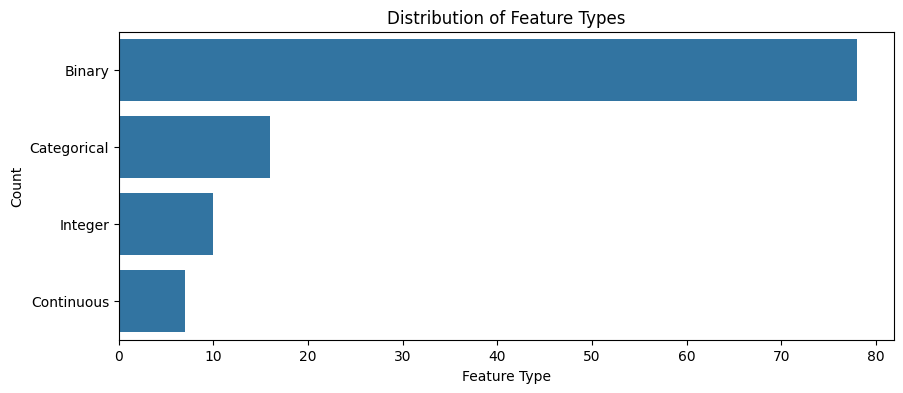

In [3]:
not_in_t0 = [93, 97, 95, 100, 101, 102, 103, 104, 105]
not_in_t0 = [x - 1 for x in not_in_t0]  # adjust for zero indexing
not_in_t24 = [94, 95, 101, 102, 104, 105]
not_in_t24 = [x - 1 for x in not_in_t24]  # adjust for zero indexing
not_in_t48 = [95, 102, 105]
not_in_t48 = [x - 1 for x in not_in_t48]  # adjust for zero indexing
not_in_t72 = []  # all features can be used at t=72h
features_t72_colIDs = np.arange(1, 112)  # all features except ID
features_t48_colIDs = np.setdiff1d(np.arange(1, 112), not_in_t48)
features_t24_colIDs = np.setdiff1d(np.arange(1, 112), not_in_t24)
features_t0_colIDs = np.setdiff1d(np.arange(1, 112), not_in_t0)
features_t72 = mi_variables.iloc[features_t72_colIDs]
features_t48 = mi_variables.iloc[features_t48_colIDs]
features_t24 = mi_variables.iloc[features_t24_colIDs]
features_t0 = mi_variables.iloc[features_t0_colIDs]
timepoint_features = {
    "t0h": features_t0['name'].tolist(),
    "t24h": features_t24['name'].tolist(),
    "t48h": features_t48['name'].tolist(),
    "t72h": features_t72['name'].tolist()
}
#label the boxes
fig, axs = plt.subplots(figsize=(10, 4))
sns.countplot(data=features_t72, y='type', ax=axs, order=features_t72['type'].value_counts().index)
axs.set_xlabel('Feature Type')
axs.set_ylabel('Count')
axs.set_title('Distribution of Feature Types')


plt.show()

#### 1.3.1 Continuous Features

Continuous Features in this dataset covers mesaurement data, like Serum potassium content, Serum CPK content, or White blood cell count. Std Encoder seems appropriate

In [4]:
continuous_feature_names = (
    features_t72.loc[features_t72['type'].str.lower() == 'continuous', 'name']
    .dropna()
    .tolist()
)
features_t72[features_t72['name'].isin(continuous_feature_names)]

name     role        type demographic  \
83    K_BLOOD  Feature  Continuous         NaN   
85   NA_BLOOD  Feature  Continuous         NaN   
86  ALT_BLOOD  Feature  Continuous         NaN   
87  AST_BLOOD  Feature  Continuous         NaN   
88  KFK_BLOOD  Feature  Continuous         NaN   
89    L_BLOOD  Feature  Continuous         NaN   
90        ROE  Feature  Continuous         NaN   

                             description               units missing_values  
83               Serum potassium content              mmol/L            yes  
85                  Serum sodium content              mmol/L            yes  
86        Serum AlAT content (ALT_BLOOD)                IU/L            yes  
87                    Serum AsAT content                IU/L            yes  
88                     Serum CPK content                IU/L            yes  
89               White blood cell count   billions per liter            yes  
90  ESR (Erythrocyte sedimentation rate)                  мм            yes

In [5]:
mi_features[continuous_feature_names]

K_BLOOD  NA_BLOOD  ALT_BLOOD  AST_BLOOD  KFK_BLOOD  L_BLOOD   ROE
0         4.7     138.0        NaN        NaN        NaN      8.0  16.0
1         3.5     132.0       0.38       0.18        NaN      7.8   3.0
2         4.0     132.0       0.30       0.11        NaN     10.8   NaN
3         3.9     146.0       0.75       0.37        NaN      NaN   NaN
4         3.5     132.0       0.45       0.22        NaN      8.3   NaN
...       ...       ...        ...        ...        ...      ...   ...
1695      3.7     130.0       1.05       0.52        NaN     12.8   6.0
1696      NaN       NaN        NaN        NaN        NaN      NaN   NaN
1697      NaN       NaN       0.23       0.15        NaN      8.3  13.0
1698      3.1     136.0       0.45       0.45        NaN      7.5   4.0
1699      NaN       NaN        NaN        NaN        NaN      NaN   NaN

[1700 rows x 7 columns]

In [6]:
mi_features[continuous_feature_names].describe()

K_BLOOD     NA_BLOOD    ALT_BLOOD    AST_BLOOD  KFK_BLOOD  \
count  1329.000000  1325.000000  1416.000000  1415.000000   4.000000   
mean      4.191422   136.550943     0.481455     0.263717   2.000000   
std       0.754076     6.512120     0.387261     0.201802   1.095445   
min       2.300000   117.000000     0.030000     0.040000   1.200000   
25%       3.700000   133.000000     0.230000     0.150000   1.350000   
50%       4.100000   136.000000     0.380000     0.220000   1.600000   
75%       4.600000   140.000000     0.610000     0.330000   2.250000   
max       8.200000   169.000000     3.000000     2.150000   3.600000   

           L_BLOOD          ROE  
count  1575.000000  1497.000000  
mean      8.782914    13.444890  
std       3.400557    11.296316  
min       2.000000     1.000000  
25%       6.400000     5.000000  
50%       8.000000    10.000000  
75%      10.450000    18.000000  
max      27.900000   140.000000

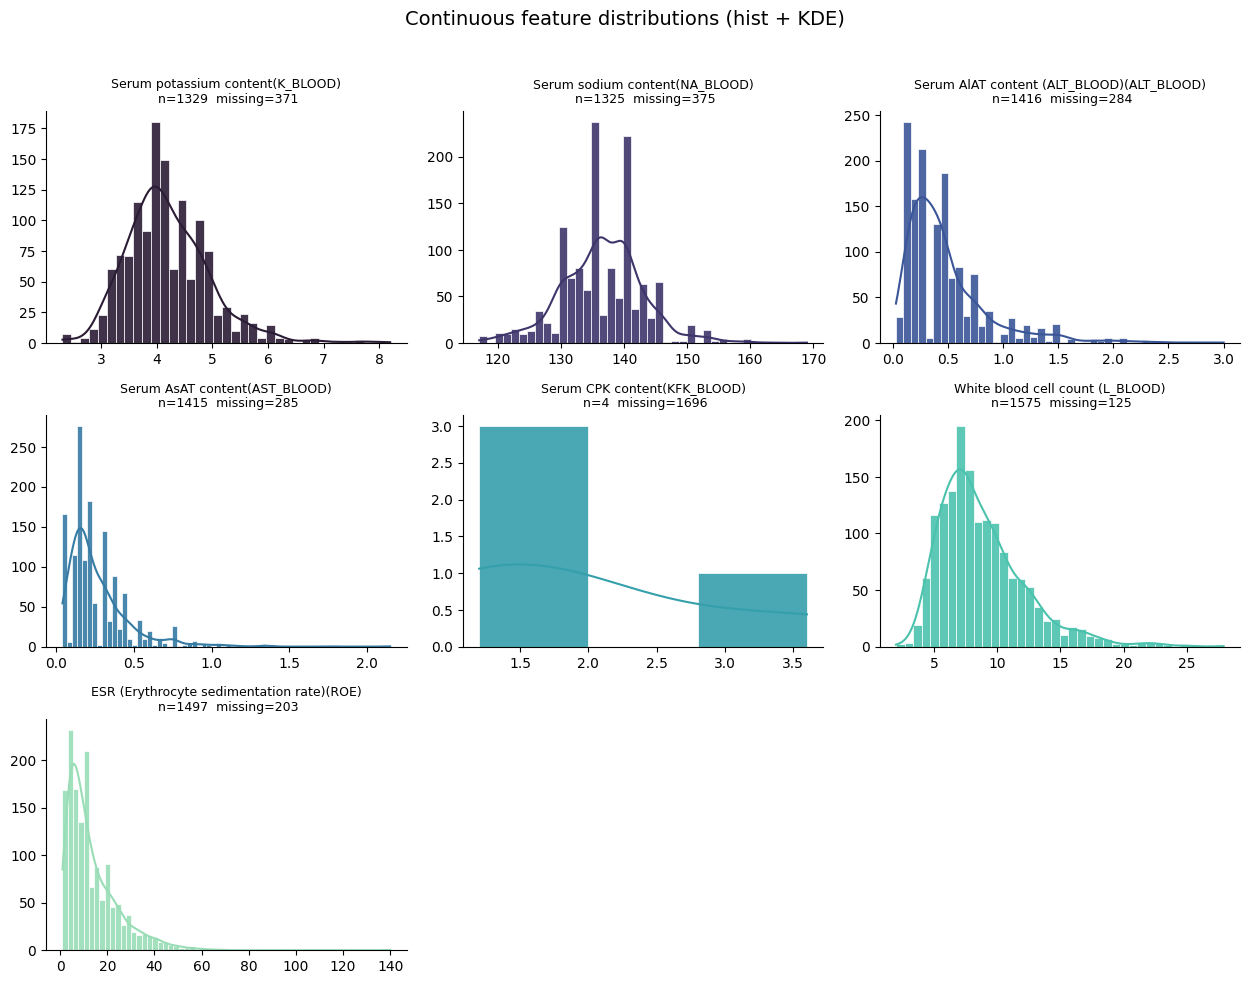

In [7]:
if not continuous_feature_names:
    print("No continuous features found.")
else:
    # Prepare data
    cont_df = mi_features[continuous_feature_names].copy()

    # Grid layout
    n = len(continuous_feature_names)
    ncols = 3
    nrows = int(np.ceil(n / ncols))

    # Figure and axes
    fig, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=(ncols * 4.2, nrows * 3.2),
        sharex=False,
        sharey=False,
    )

    # Ensure axes is a flat array
    if isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else:
        axes = np.array([axes])

    # Color palette
    palette = sns.color_palette("mako", n)

    # Plot each feature
    for i, col in enumerate(continuous_feature_names):
        ax = axes[i]
        s = cont_df[col].dropna()

        # Histogram with KDE overlay
        sns.histplot(
            s,
            bins='auto',
            kde=True,
            ax=ax,
            color=palette[i % len(palette)],
            edgecolor='white',
            linewidth=0.5,
            alpha=0.9,
        )

        # Titles and labels
        missing = cont_df[col].isna().sum()
        ax.set_title(f"{features_t72[features_t72['name'] == col]['description'].values[0]}({col})\n n={len(s)}  missing={missing}", fontsize=9)
        ax.set_xlabel("")
        ax.set_ylabel("")
        sns.despine(ax=ax)

    # Hide any unused subplots
    for j in range(n, len(axes)):
        axes[j].axis('off')

    fig.suptitle("Continuous feature distributions (hist + KDE)", fontsize=14, y=1.02)
    plt.tight_layout()


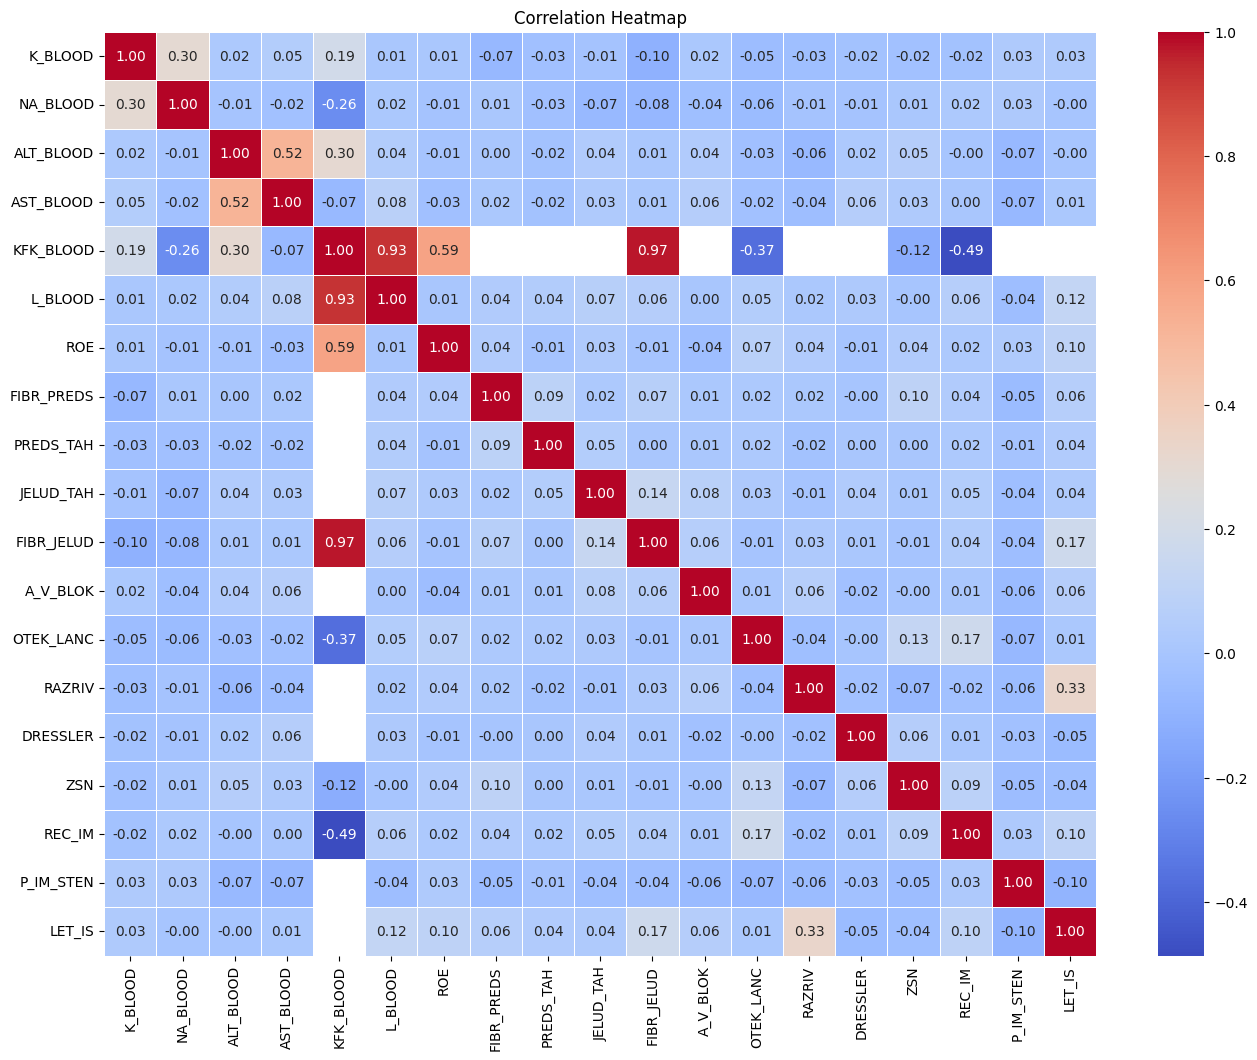

In [8]:
matrix = pd.concat(
    [mi_features[continuous_feature_names], mi_targets],
    axis=1
).corr()

plt.figure(figsize=(16,12))
sns.heatmap(matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

#### 1.3.2 Integer Features

In [9]:
integer_feature_names = (
    features_t72.loc[features_t72['type'].str.lower() == 'integer', 'name']
    .dropna()
    .tolist()
)
features_t72[features_t72['name'].isin(integer_feature_names)]

name     role     type demographic  \
1           AGE  Feature  Integer         Age   
34   S_AD_KBRIG  Feature  Integer         NaN   
35   D_AD_KBRIG  Feature  Integer         NaN   
36    S_AD_ORIT  Feature  Integer         NaN   
37    D_AD_ORIT  Feature  Integer         NaN   
99     NA_R_1_n  Feature  Integer         NaN   
100    NA_R_2_n  Feature  Integer         NaN   
101    NA_R_3_n  Feature  Integer         NaN   
103  NOT_NA_2_n  Feature  Integer         NaN   
104  NOT_NA_3_n  Feature  Integer         NaN   

                                           description units missing_values  
1                                      Age of patient.   NaN             no  
34   Systolic blood pressure according to Emergency...  mmHg            yes  
35   Diastolic blood pressure according to Emergenc...  mmHg            yes  
36   Systolic blood pressure according to intensive...  mmHg            yes  
37   Diastolic blood pressure according to intensiv...  mmHg            yes  
99   Use of opioid drugs in the ICU in the first ho...   NaN            yes  
100  Use of opioid drugs in the ICU in the second d...   NaN            yes  
101  Use of opioid drugs in the ICU in the third da...   NaN            yes  
103  Use of NSAIDs in the ICU in the second day of ...   NaN            yes  
104  Use of NSAIDs in the ICU in the third day of t...   NaN            yes

In [10]:
mi_features[integer_feature_names].describe()

AGE  S_AD_KBRIG  D_AD_KBRIG    S_AD_ORIT    D_AD_ORIT  \
count  1692.000000  624.000000  624.000000  1433.000000  1433.000000   
mean     61.856974  136.907051   81.394231   134.588276    82.749477   
std      11.259936   34.997835   19.745045    31.348388    18.321063   
min      26.000000    0.000000    0.000000     0.000000     0.000000   
25%      54.000000  120.000000   70.000000   120.000000    80.000000   
50%      63.000000  140.000000   80.000000   130.000000    80.000000   
75%      70.000000  160.000000   90.000000   150.000000    90.000000   
max      92.000000  260.000000  190.000000   260.000000   190.000000   

          NA_R_1_n     NA_R_2_n     NA_R_3_n   NOT_NA_2_n   NOT_NA_3_n  
count  1695.000000  1592.000000  1569.000000  1590.000000  1569.000000  
mean      0.484956     0.094221     0.058636     0.113208     0.084767  
std       0.779522     0.356203     0.275030     0.399514     0.355107  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000     0.000000     0.000000  
50%       0.000000     0.000000     0.000000     0.000000     0.000000  
75%       1.000000     0.000000     0.000000     0.000000     0.000000  
max       4.000000     3.000000     2.000000     3.000000     2.000000

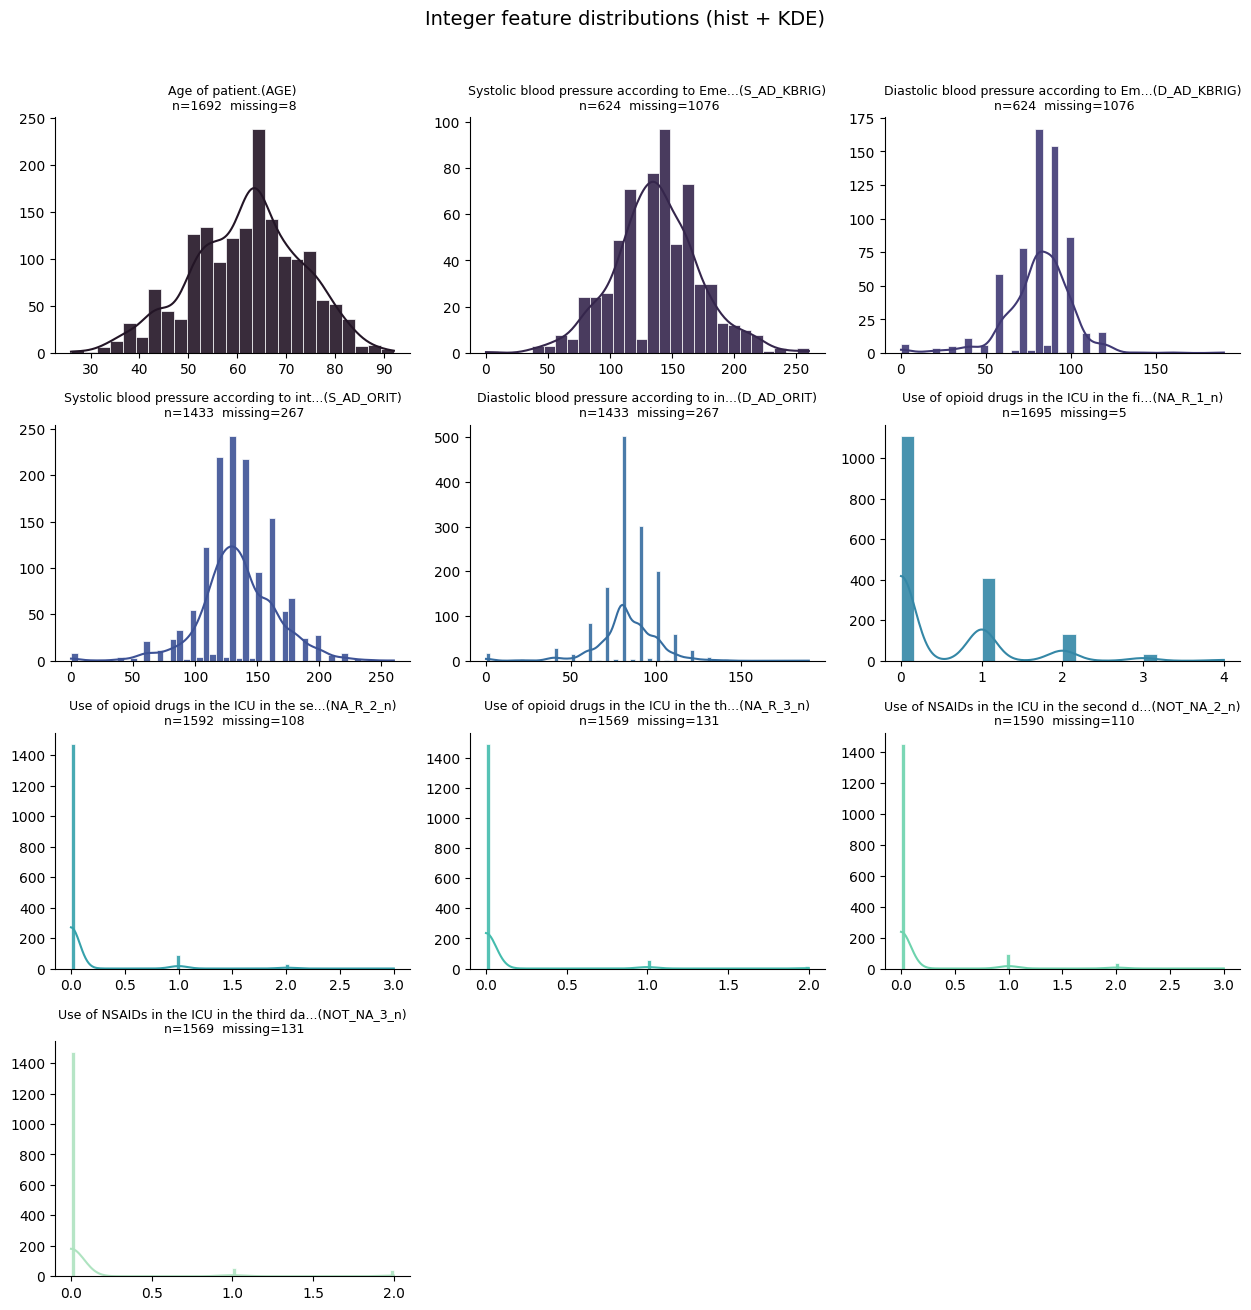

In [11]:
if not integer_feature_names:
    print("No integer features found.")
else:
    # Prepare data
    int_df = mi_features[integer_feature_names].copy()

    # Grid layout
    n = len(integer_feature_names)
    ncols = 3
    nrows = int(np.ceil(n / ncols))

    # Figure and axes
    fig, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=(ncols * 4.2, nrows * 3.2),
        sharex=False,
        sharey=False,
    )

    # Ensure axes is a flat array
    if isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else:
        axes = np.array([axes])

    # Color palette
    palette = sns.color_palette("mako", n)

    # Plot each feature
    for i, col in enumerate(integer_feature_names):
        ax = axes[i]
        s = int_df[col].dropna()

        # Histogram with KDE overlay
        sns.histplot(
            s,
            bins='auto',
            kde=True,
            ax=ax,
            color=palette[i % len(palette)],
            edgecolor='white',
            linewidth=0.5,
            alpha=0.9,
        )

        # Titles and labels
        missing = int_df[col].isna().sum()
        # Limit title to 20 characters
        desc = features_t72[features_t72['name'] == col]['description'].values[0]
        short_desc = desc[:40] + "..." if len(desc) > 20 else desc
        ax.set_title(f"{short_desc}({col})\n n={len(s)}  missing={missing}", fontsize=9)
        ax.set_xlabel("")
        ax.set_ylabel("")
        sns.despine(ax=ax)

    # Hide any unused subplots
    for j in range(n, len(axes)):
        axes[j].axis('off')

    fig.suptitle("Integer feature distributions (hist + KDE)", fontsize=14, y=1.02)
    plt.tight_layout()


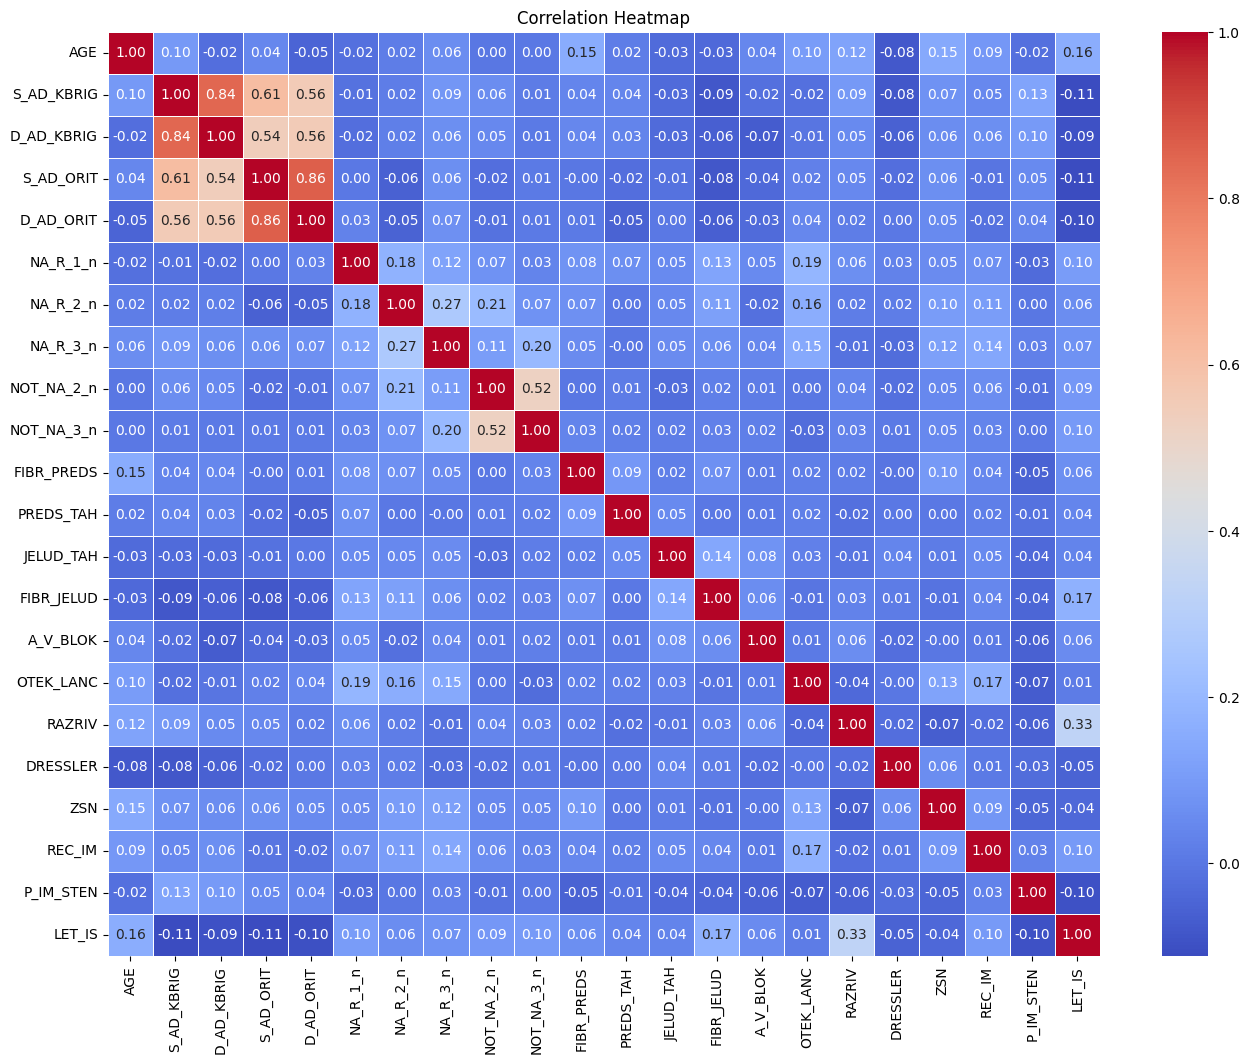

In [12]:
matrix = pd.concat(
    [mi_features[integer_feature_names], mi_targets],
    axis=1
).corr()

plt.figure(figsize=(16,12))
sns.heatmap(matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

#### 1.3.3 Categorical Features

In [13]:
categorical_feature_names = (
    features_t72.loc[features_t72['type'].str.lower() == 'categorical', 'name']
    .dropna()
    .tolist()
)
features_t72[features_t72['name'].isin(categorical_feature_names)]

name     role         type demographic  \
3      INF_ANAM  Feature  Categorical         NaN   
4     STENOK_AN  Feature  Categorical         NaN   
5     FK_STENOK  Feature  Categorical         NaN   
6      IBS_POST  Feature  Categorical         NaN   
8            GB  Feature  Categorical         NaN   
10      DLIT_AG  Feature  Categorical         NaN   
11        ZSN_A  Feature  Categorical         NaN   
44       ant_im  Feature  Categorical         NaN   
45       lat_im  Feature  Categorical         NaN   
46       inf_im  Feature  Categorical         NaN   
47      post_im  Feature  Categorical         NaN   
91     TIME_B_S  Feature  Categorical         NaN   
92     R_AB_1_n  Feature  Categorical         NaN   
93     R_AB_2_n  Feature  Categorical         NaN   
94     R_AB_3_n  Feature  Categorical         NaN   
102  NOT_NA_1_n  Feature  Categorical         NaN   

                                           description units missing_values  
3    Quantity of myocardial infarctions in the anam...   NaN            yes  
4    Exertional angina pectoris in the anamnesis. \...   NaN            yes  
5    Functional class (FC) of angina pectoris in th...   NaN            yes  
6    Coronary heart disease (CHD) in recent weeks, ...   NaN            yes  
8    Presence of an essential hypertension \n\n0: t...   NaN            yes  
10   there was no arterial hypertension\n\n1: one y...   NaN            yes  
11   Presence of chronic Heart failure (HF) in the ...   NaN            yes  
44   Presence of an anterior myocardial infarction ...   NaN            yes  
45   Presence of a lateral myocardial infarction (l...   NaN            yes  
46   Presence of an inferior myocardial infarction ...   NaN            yes  
47   Presence of a posterior myocardial infarction ...   NaN            yes  
91   Time elapsed from the beginning of the attack ...   NaN            yes  
92   Relapse of the pain in the first hours of the ...   NaN            yes  
93   Relapse of the pain in the second day of the h...   NaN            yes  
94   Relapse of the pain in the third day of the ho...   NaN            yes  
102  Use of NSAIDs in the ICU in the first hours of...   NaN            yes

In [14]:
# Categorical feature code-to-meaning mappings
categorical_feature_mappings = {
    # Quantity of myocardial infarctions in the anamnesis.
    "INF_ANAM": {
        0: "zero",
        1: "one",
        2: "two",
        3: "three and more",
    },

    # Exertional angina pectoris in the anamnesis.
    "STENOK_AN": {
        0: "never",
        1: "during the last year",
        2: "one year ago",
        3: "two years ago",
        4: "three years ago",
        5: "4-5 years ago",
        6: "more than 5 years ago",
    },

    # Functional class (FC) of angina pectoris in the last year.
    "FK_STENOK": {
        0: "there is no angina pectoris",
        1: "I FC",
        2: "II FC",
        3: "III FC",
        4: "IV FC",
    },

    # Coronary heart disease (CHD) in recent weeks/days before admission to hospital.
    "IBS_POST": {
        0: "none",
        1: "exertional angina pectoris",
        2: "unstable angina pectoris",
    },

    # Presence of essential hypertension.
    "GB": {
        0: "there is no essential hypertension",
        1: "Stage 1",
        2: "Stage 2",
        3: "Stage 3",
    },

    # Duration of arterial hypertension; 0 indicates no arterial hypertension.
    "DLIT_AG": {
        0: "there was no arterial hypertension",
        1: "one year",
        2: "two years",
        3: "three years",
        4: "four years",
        5: "five years",
        6: "6-10 years",
        7: "more than 10 years",
    },

    # Presence of chronic heart failure (partially ordered):
    # 0 < 1 < 2 < 4 and 0 < 1 < 3 < 4; state 4 = simultaneous states 2 and 3.
    "ZSN_A": {
        0: "there is no chronic heart failure",
        1: "I stage",
        2: "II stage (heart failure due to right ventricular systolic dysfunction)",
        3: "II stage (heart failure due to left ventricular systolic dysfunction)",
        4: "IIB stage (heart failure due to left and right ventricular systolic dysfunction)",
    },

    # Presence of an anterior myocardial infarction (ECG leads V1–V4).
    "ant_im": {
        0: "there is no infarct in this location",
        1: "QRS has no changes",
        2: "QRS is like QR-complex",
        3: "QRS is like Qr-complex",
        4: "QRS is like QS-complex",
    },

    # Presence of a lateral myocardial infarction (ECG leads V5–V6, I, aVL).
    "lat_im": {
        0: "there is no infarct in this location",
        1: "QRS has no changes",
        2: "QRS is like QR-complex",
        3: "QRS is like Qr-complex",
        4: "QRS is like QS-complex",
    },

    # Presence of an inferior myocardial infarction (ECG leads III, aVF, II).
    "inf_im": {
        0: "there is no infarct in this location",
        1: "QRS has no changes",
        2: "QRS is like QR-complex",
        3: "QRS is like Qr-complex",
        4: "QRS is like QS-complex",
    },

    # Presence of a posterior myocardial infarction (ECG V7–V9; reciprocity V1–V3).
    "post_im": {
        0: "there is no infarct in this location",
        1: "QRS has no changes",
        2: "QRS is like QR-complex",
        3: "QRS is like Qr-complex",
        4: "QRS is like QS-complex",
    },

    # Time elapsed from the beginning of the attack of CHD to hospital.
    "TIME_B_S": {
        1: "less than 2 hours",
        2: "2-4 hours",
        3: "4-6 hours",
        4: "6-8 hours",
        5: "8-12 hours",
        6: "12-24 hours",
        7: "more than 1 days",
        8: "more than 2 days",
        9: "more than 3 days",
    },

    # Relapse of the pain in the first hours of the hospital period.
    "R_AB_1_n": {
        0: "there is no relapse",
        1: "only one",
        2: "2 times",
        3: "3 or more times",
    },

    # Relapse of the pain in the second day of the hospital period.
    "R_AB_2_n": {
        0: "there is no relapse",
        1: "only one",
        2: "2 times",
        3: "3 or more times",
    },

    # Relapse of the pain in the third day of the hospital period.
    "R_AB_3_n": {
        0: "there is no relapse",
        1: "only one",
        2: "2 times",
        3: "3 or more times",
    },

    # Use of NSAIDs in the ICU in the first hours of the hospital period.
    "NOT_NA_1_n": {
        0: "no",
        1: "once",
        2: "twice",
        3: "three times",
        4: "four or more times",
    },
}
categorical_feature_ordering = {
    "INF_ANAM": "ordinal",     # quantity of prior MIs (0<1<2<3)
    "STENOK_AN": "ordinal",    # recency of exertional angina (never < last year < 1y < 2y < 3y < 4-5y)
    "FK_STENOK": "ordinal",    # I–IV functional class
    "IBS_POST": "nominal",     # CHD status types (none/exertional/unstable) – no strict order
    "GB": "ordinal",           # hypertension stage (none < 1 < 2 < 3)
    "DLIT_AG": "ordinal",      # duration of hypertension (none < 1y < 2y < ... < >10y)
    "ZSN_A": "ordinal",        # chronic HF (partially ordered: 0<1<2<4 and 0<1<3<4)
    "ant_im": "nominal",       # ECG pattern type in anterior leads – treat as nominal
    "lat_im": "nominal",       # ECG pattern type in lateral leads – treat as nominal
    "inf_im": "nominal",       # ECG pattern type in inferior leads – treat as nominal
    "post_im": "nominal",      # ECG pattern type in posterior leads – treat as nominal
    "TIME_B_S": "ordinal",     # elapsed time buckets (increasing hours/days)
    "R_AB_1_n": "ordinal",     # relapse count buckets (0 < 1 < 2 < 3+)
    "R_AB_2_n": "ordinal",     # relapse count buckets (0 < 1 < 2 < 3+)
    "R_AB_3_n": "ordinal",     # relapse count buckets (0 < 1 < 2 < 3+)
    "NOT_NA_1_n": "ordinal",   # NSAID usage frequency (0 < 1 < 2 < 3 < 4+)
}

In [15]:
mi_features[categorical_feature_names]

INF_ANAM  STENOK_AN  FK_STENOK  IBS_POST   GB  DLIT_AG  ZSN_A  ant_im  \
0          2.0        1.0        1.0       2.0  3.0      7.0    0.0     1.0   
1          1.0        0.0        0.0       0.0  0.0      0.0    0.0     4.0   
2          0.0        0.0        0.0       2.0  2.0      2.0    0.0     4.0   
3          0.0        0.0        0.0       2.0  2.0      3.0    1.0     0.0   
4          0.0        0.0        0.0       2.0  3.0      7.0    0.0     4.0   
...        ...        ...        ...       ...  ...      ...    ...     ...   
1695       0.0        4.0        2.0       1.0  2.0      7.0    0.0     NaN   
1696       0.0        6.0        2.0       1.0  2.0      7.0    0.0     0.0   
1697       3.0        6.0        2.0       2.0  0.0      0.0    0.0     4.0   
1698       2.0        2.0        2.0       1.0  2.0      7.0    NaN     NaN   
1699       2.0        NaN        NaN       NaN  2.0      NaN    4.0     0.0   

      lat_im  inf_im  post_im  TIME_B_S  R_AB_1_n  R_AB_2_n  R_AB_3_n  \
0        0.0     0.0      0.0       4.0       0.0       0.0       1.0   
1        1.0     0.0      0.0       2.0       0.0       0.0       0.0   
2        1.0     0.0      0.0       3.0       3.0       0.0       0.0   
3        1.0     1.0      0.0       2.0       0.0       0.0       1.0   
4        1.0     0.0      0.0       9.0       0.0       0.0       0.0   
...      ...     ...      ...       ...       ...       ...       ...   
1695     NaN     0.0      0.0       2.0       0.0       NaN       NaN   
1696     0.0     2.0      1.0       2.0       0.0       NaN       NaN   
1697     1.0     0.0      0.0       1.0       2.0       0.0       0.0   
1698     NaN     NaN      NaN       2.0       1.0       NaN       NaN   
1699     0.0     2.0      0.0       1.0       0.0       NaN       NaN   

      NOT_NA_1_n  
0            0.0  
1            1.0  
2            3.0  
3            0.0  
4            0.0  
...          ...  
1695         0.0  
1696         0.0  
1697         0.0  
1698         1.0  
1699         0.0  

[1700 rows x 16 columns]

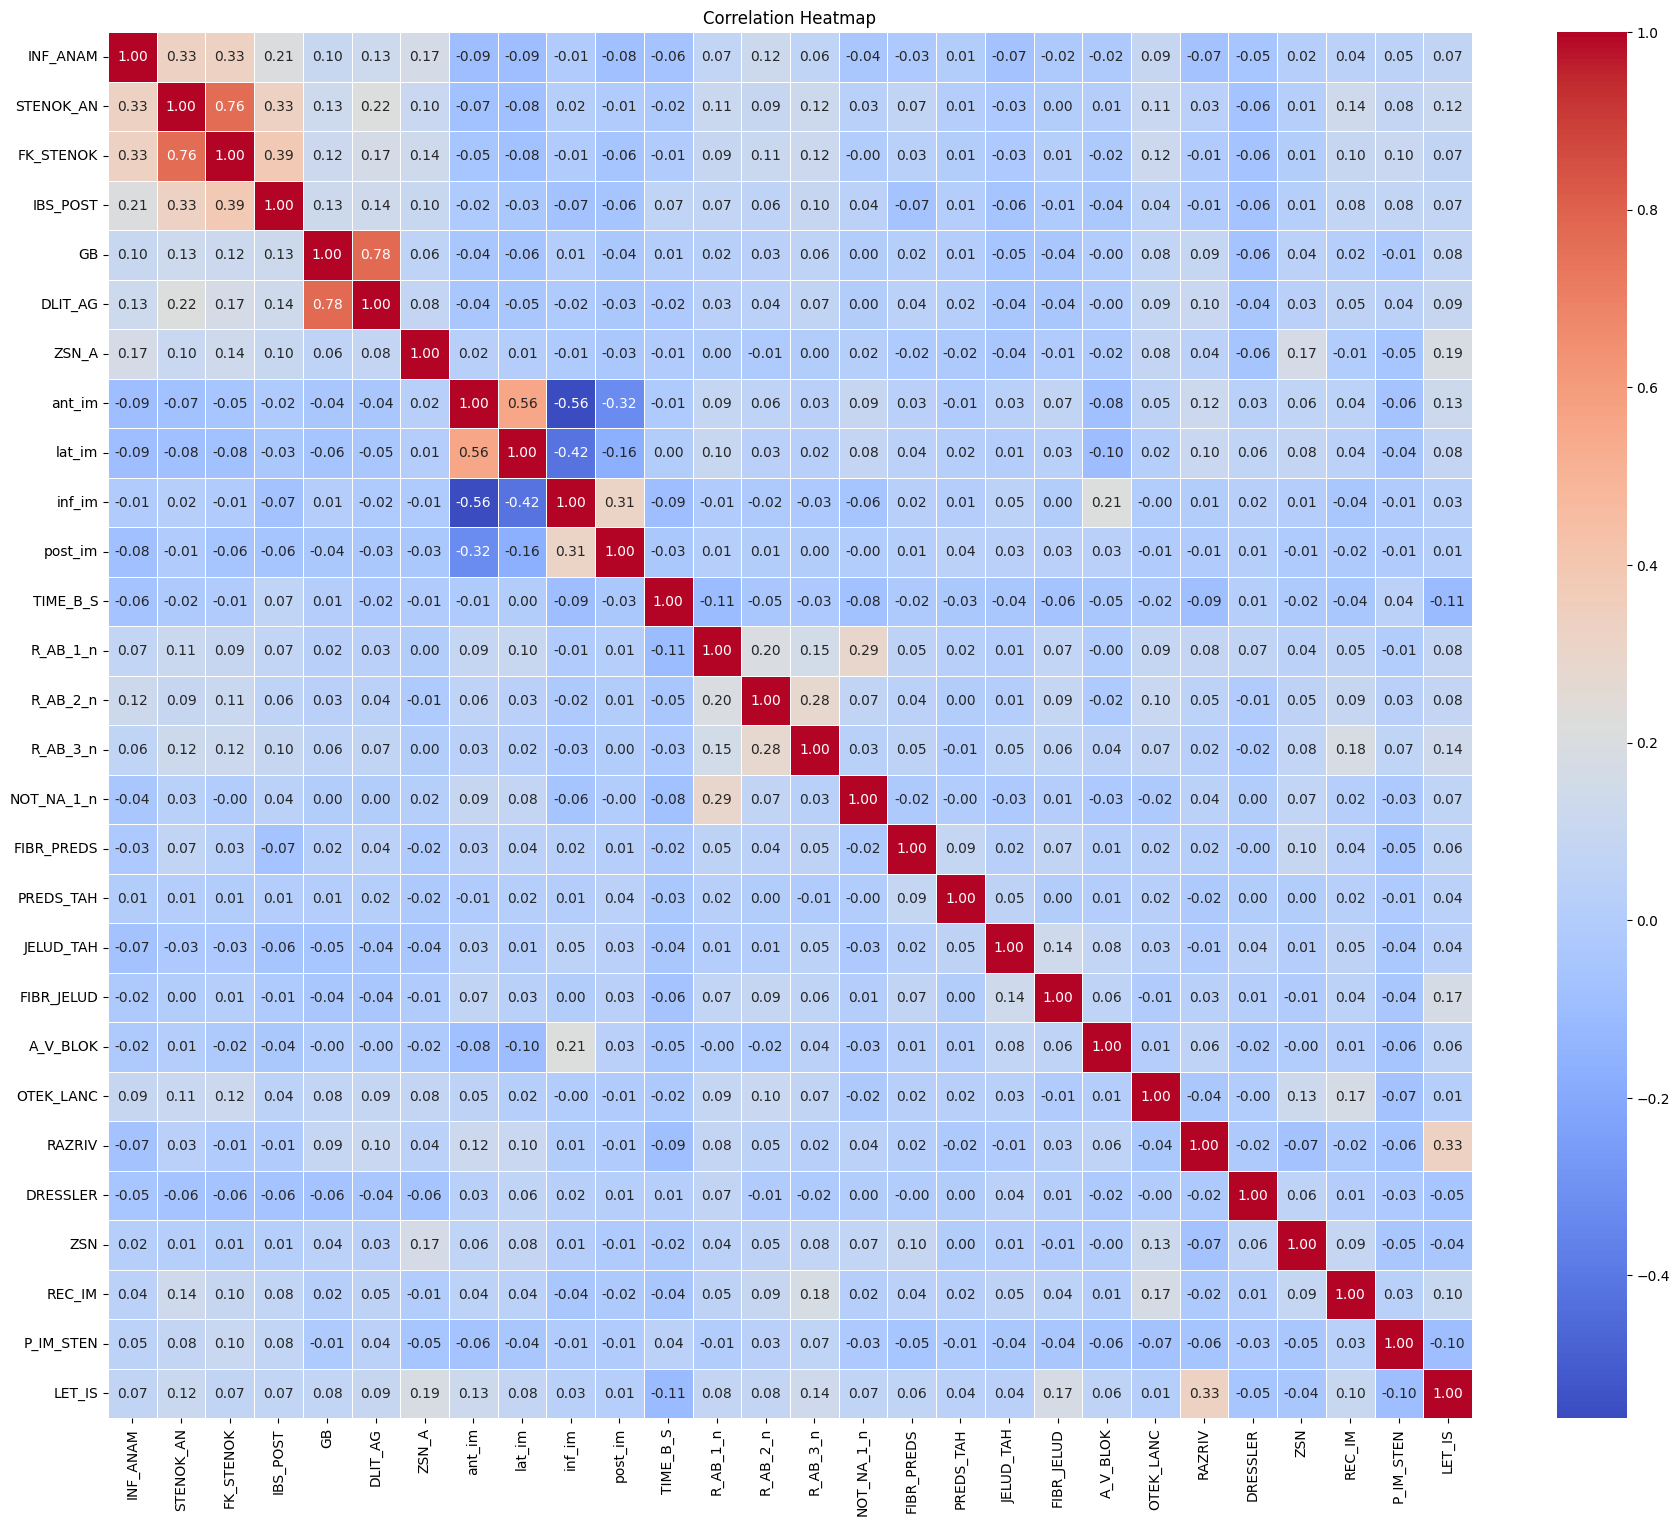

In [16]:
# Correlation Matrix including categorical features
matrix = pd.concat(
    [mi_features[categorical_feature_names], mi_targets],
    axis=1
).corr()
plt.figure(figsize=(22,18))
sns.heatmap(matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

#### 1.3.4 Binary Features

In [17]:
binary_feature_names = (
    features_t72.loc[features_t72['type'].str.lower() == 'binary', 'name']
    .dropna()
    .tolist()
)
features_t72[features_t72['name'].isin(binary_feature_names)]

name     role    type demographic  \
2           SEX  Feature  Binary         Sex   
7      IBS_NASL  Feature  Binary         NaN   
9    SIM_GIPERT  Feature  Binary         NaN   
12        nr_11  Feature  Binary         NaN   
13        nr_01  Feature  Binary         NaN   
..          ...      ...     ...         ...   
107  ANT_CA_S_n  Feature  Binary         NaN   
108   GEPAR_S_n  Feature  Binary         NaN   
109     ASP_S_n  Feature  Binary         NaN   
110    TIKL_S_n  Feature  Binary         NaN   
111   TRENT_S_n  Feature  Binary         NaN   

                                           description units missing_values  
2                                   0: female, 1: male   NaN             no  
7    Heredity on CHD\n\n0: isn't burdened\n\n1: bur...   NaN            yes  
9                             Symptomatic hypertension   NaN            yes  
12            Observing of arrhythmia in the anamnesis   NaN            yes  
13      Premature atrial contractions in the anamnesis   NaN            yes  
..                                                 ...   ...            ...  
107         Use of calcium channel blockers in the ICU   NaN            yes  
108       Use of а anticoagulants (heparin) in the ICU   NaN            yes  
109            Use of acetylsalicylic acid in the ICU    NaN            yes  
110                           Use of Ticlid in the ICU   NaN            yes  
111                          Use of Trental in the ICU   NaN            yes  

[78 rows x 7 columns]

In [18]:
# Correlation Matrix including binary features
matrix = pd.concat(
    [mi_features[binary_feature_names], mi_targets],
    axis=1
).corr()
plt.figure(figsize=(100,100))
sns.heatmap(matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

### 1.4 Target Variables

The target variables are:
- **FIBR_PREDS**: Atrial fibrillation (Binary)
- **PREDS_TAH**: Supraventricular tachycardia (Binary)
- **JELUD_TAH**: Ventricular tachycardia (Binary)
- **FIBR_JELUD**: Ventricular fabrillation (Binary)
- **A_V_BLOCK**: Third-degreee AV block (Binary)
- **ATEK_LANC**: Pulmonary edema (Binary)
- **RAZRIV**: Myocardial rupture (Binary)
- **DRESSLER**: Dressler Syndrome (Binary)
- **ZSN**: Chronic Heart Failure (Binary)
- **REC_IM**: Relapse of the myocardial infarction (Binary)
- **P_IM_STEN**: Post-infarction angina (Binary)
- **LET_IS**: Lethal outcome (Categorical):
    - 0: unknonw (alive)
    - 1: cardiogenic shock
    - 2: pulmonary edema
    - 3: myocardial rupture
    - 4: progress of congestive heart failure
    - 5: thromboembolism
    - 6: asystole
    - 7: ventricular fibrillation


In [19]:
mi_target_variables = mi_variables[mi_variables['role'].str.lower() == 'target'].copy()
mi_target_variables["count"] = 0
for i in mi_target_variables.index:
    if mi_target_variables.loc[i, "type"].lower() == 'binary':
        mi_target_variables.loc[i, "count"] = mi_targets[mi_target_variables.loc[i, "name"]].sum()
    else:
        mi_target_variables.loc[i, "count"] = mi_targets[mi_target_variables.loc[i, "name"]].count()
mi_target_variables

name    role         type demographic  \
112  FIBR_PREDS  Target       Binary         NaN   
113   PREDS_TAH  Target       Binary         NaN   
114   JELUD_TAH  Target       Binary         NaN   
115  FIBR_JELUD  Target       Binary         NaN   
116    A_V_BLOK  Target       Binary         NaN   
117   OTEK_LANC  Target       Binary         NaN   
118      RAZRIV  Target       Binary         NaN   
119    DRESSLER  Target       Binary         NaN   
120         ZSN  Target       Binary         NaN   
121      REC_IM  Target       Binary         NaN   
122   P_IM_STEN  Target       Binary         NaN   
123      LET_IS  Target  Categorical         NaN   

                                           description units missing_values  \
112                                Atrial fibrillation   NaN             no   
113                       Supraventricular tachycardia   NaN             no   
114                            Ventricular tachycardia   NaN             no   
115                           Ventricular fibrillation   NaN             no   
116                              Third-degree AV block   NaN             no   
117                                    Pulmonary edema   NaN             no   
118                                Myocardial rupture    NaN             no   
119                                  Dressler syndrome   NaN             no   
120                              Chronic heart failure   NaN             no   
121               Relapse of the myocardial infarction   NaN             no   
122                             Post-infarction angina   NaN             no   
123  Lethal outcome (cause)\n\n0: unknown (alive)\n...   NaN             no   

     count  
112    170  
113     20  
114     42  
115     71  
116     57  
117    159  
118     54  
119     75  
120    394  
121    159  
122    148  
123   1700

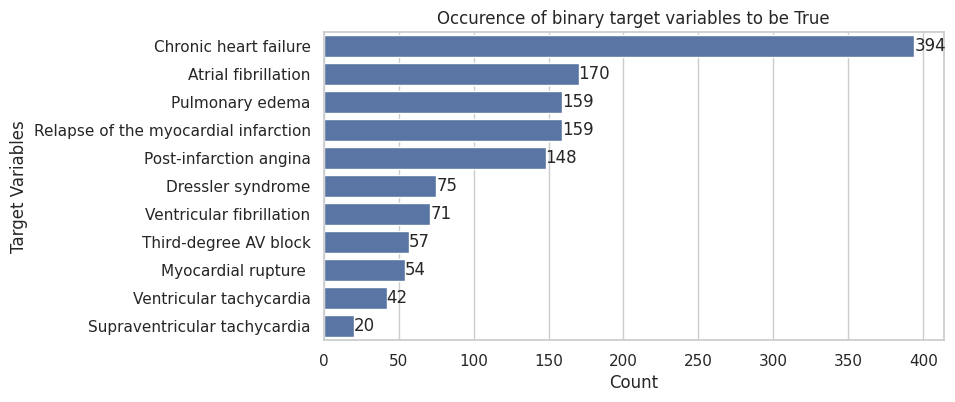

In [20]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 4))
data = mi_target_variables[mi_target_variables["type"].str.lower() == "binary"].sort_values(by="count", ascending=False)
ax = sns.barplot(x="count", y="description", data=data, orient="h")
ax.set_title("Occurence of binary target variables to be True")
ax.set_xlabel("Count")
ax.set_ylabel("Target Variables")
abs_values = data["count"].values
ax.bar_label(container=ax.containers[0], labels=abs_values)
plt.show()

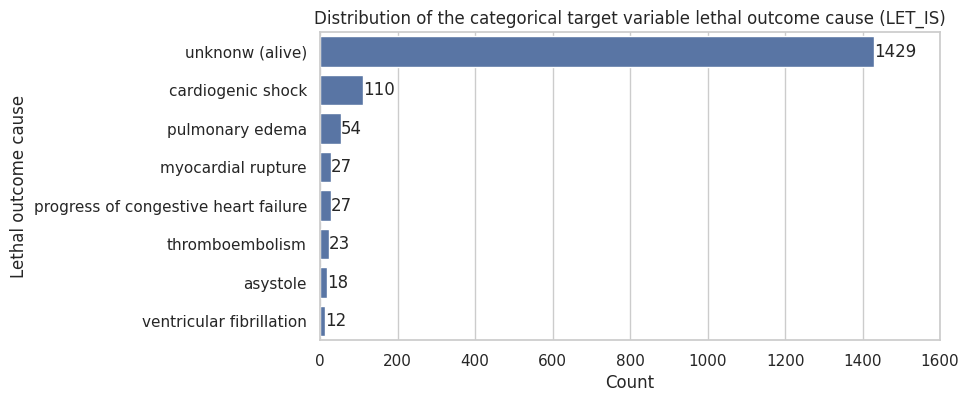

In [21]:
LET_IS_MAPPING = {
    0: "unknonw (alive)",
    1: "cardiogenic shock",
    2: "pulmonary edema",
    3: "myocardial rupture",
    4: "progress of congestive heart failure",
    5: "thromboembolism",
    6: "asystole",
    7: "ventricular fibrillation"
}
plt.figure(figsize=(8, 4))
ax = sns.countplot(data=mi_targets, y='LET_IS', order=mi_targets['LET_IS'].value_counts().index)
ax.set_yticks(ticks=list(LET_IS_MAPPING.keys()), labels=list(LET_IS_MAPPING.values()), ha='right')
ax.set_title('Distribution of the categorical target variable lethal outcome cause (LET_IS)')
ax.set_ylabel('Lethal outcome cause')
ax.set_xlabel('Count')
ax.set_xlim(0, 1600)
abs_values = mi_targets['LET_IS'].value_counts(ascending=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values)
plt.show()


## 2 Data Cleaning

### 2.1 Data Types

#### 2.1.1 Feature Data Types

In [22]:
print(continuous_feature_names)
print(integer_feature_names)
print(categorical_feature_names)
print(binary_feature_names)

['K_BLOOD', 'NA_BLOOD', 'ALT_BLOOD', 'AST_BLOOD', 'KFK_BLOOD', 'L_BLOOD', 'ROE']
['AGE', 'S_AD_KBRIG', 'D_AD_KBRIG', 'S_AD_ORIT', 'D_AD_ORIT', 'NA_R_1_n', 'NA_R_2_n', 'NA_R_3_n', 'NOT_NA_2_n', 'NOT_NA_3_n']
['INF_ANAM', 'STENOK_AN', 'FK_STENOK', 'IBS_POST', 'GB', 'DLIT_AG', 'ZSN_A', 'ant_im', 'lat_im', 'inf_im', 'post_im', 'TIME_B_S', 'R_AB_1_n', 'R_AB_2_n', 'R_AB_3_n', 'NOT_NA_1_n']
['SEX', 'IBS_NASL', 'SIM_GIPERT', 'nr_11', 'nr_01', 'nr_02', 'nr_03', 'nr_04', 'nr_07', 'nr_08', 'np_01', 'np_04', 'np_05', 'np_07', 'np_08', 'np_09', 'np_10', 'endocr_01', 'endocr_02', 'endocr_03', 'zab_leg_01', 'zab_leg_02', 'zab_leg_03', 'zab_leg_04', 'zab_leg_06', 'O_L_POST', 'K_SH_POST', 'MP_TP_POST', 'SVT_POST', 'GT_POST', 'FIB_G_POST', 'IM_PG_P', 'ritm_ecg_p_01', 'ritm_ecg_p_02', 'ritm_ecg_p_04', 'ritm_ecg_p_06', 'ritm_ecg_p_07', 'ritm_ecg_p_08', 'n_r_ecg_p_01', 'n_r_ecg_p_02', 'n_r_ecg_p_03', 'n_r_ecg_p_04', 'n_r_ecg_p_05', 'n_r_ecg_p_06', 'n_r_ecg_p_08', 'n_r_ecg_p_09', 'n_r_ecg_p_10', 'n_p_ecg_p_

In [23]:
mi_features[continuous_feature_names].dtypes

K_BLOOD      float64
NA_BLOOD     float64
ALT_BLOOD    float64
AST_BLOOD    float64
KFK_BLOOD    float64
L_BLOOD      float64
ROE          float64
dtype: object

In [24]:
mi_features[integer_feature_names] = mi_features[integer_feature_names].astype('Int64')
mi_features[integer_feature_names].dtypes

AGE           Int64
S_AD_KBRIG    Int64
D_AD_KBRIG    Int64
S_AD_ORIT     Int64
D_AD_ORIT     Int64
NA_R_1_n      Int64
NA_R_2_n      Int64
NA_R_3_n      Int64
NOT_NA_2_n    Int64
NOT_NA_3_n    Int64
dtype: object

In [25]:
mi_features[categorical_feature_names] = mi_features[categorical_feature_names].astype('category')
for col in mi_features[categorical_feature_names]:
    print(f"{col}: {mi_features[col].dtype} ({categorical_feature_ordering[col]})")

INF_ANAM: category (ordinal)
STENOK_AN: category (ordinal)
FK_STENOK: category (ordinal)
IBS_POST: category (nominal)
GB: category (ordinal)
DLIT_AG: category (ordinal)
ZSN_A: category (ordinal)
ant_im: category (nominal)
lat_im: category (nominal)
inf_im: category (nominal)
post_im: category (nominal)
TIME_B_S: category (ordinal)
R_AB_1_n: category (ordinal)
R_AB_2_n: category (ordinal)
R_AB_3_n: category (ordinal)
NOT_NA_1_n: category (ordinal)


In [26]:
mi_features[binary_feature_names] = mi_features[binary_feature_names].astype('boolean')
mi_features[binary_feature_names].dtypes

SEX           boolean
IBS_NASL      boolean
SIM_GIPERT    boolean
nr_11         boolean
nr_01         boolean
               ...   
ANT_CA_S_n    boolean
GEPAR_S_n     boolean
ASP_S_n       boolean
TIKL_S_n      boolean
TRENT_S_n     boolean
Length: 78, dtype: object

#### 2.1.2 Target Data Types

In [27]:
mi_targets[mi_target_variables[mi_target_variables['type'].str.lower() == 'binary']["name"]] = mi_targets[mi_target_variables[mi_target_variables['type'].str.lower() == 'binary']["name"]].astype('boolean')
mi_targets[mi_target_variables[mi_target_variables['type'].str.lower() == 'categorical']["name"]] = mi_targets[mi_target_variables[mi_target_variables['type'].str.lower() == 'categorical']["name"]].astype('category')
mi_targets.dtypes

FIBR_PREDS     boolean
PREDS_TAH      boolean
JELUD_TAH      boolean
FIBR_JELUD     boolean
A_V_BLOK       boolean
OTEK_LANC      boolean
RAZRIV         boolean
DRESSLER       boolean
ZSN            boolean
REC_IM         boolean
P_IM_STEN      boolean
LET_IS        category
dtype: object

### 2.2 Duplicates

#### 2.2.1 Feature Data Duplicates

In [28]:
# show count of duplicated rows in feature data
mi_features.duplicated().sum()

np.int64(0)

#### 2.2.2 Target Data Duplicates

In [29]:
# show count of duplicated rows in target data
mi_targets.reset_index().duplicated().sum()

np.int64(0)

### 2.3 Missing Values

In [30]:
mi_features_cleaned = mi_features.copy()

Some missing values will be treated by the medical saying "**If it isn't documented, it did not happen!**". Especially some variables that indicate the usage of drugs by the emergency team! If the variable "usage of opioid drugs is NA, then I wil assume, that it did not happen.

#### 2.3.1 Feature Data Missing Values

In [31]:
print(continuous_feature_names)
print(integer_feature_names)
print(categorical_feature_names)
print(binary_feature_names)

['K_BLOOD', 'NA_BLOOD', 'ALT_BLOOD', 'AST_BLOOD', 'KFK_BLOOD', 'L_BLOOD', 'ROE']
['AGE', 'S_AD_KBRIG', 'D_AD_KBRIG', 'S_AD_ORIT', 'D_AD_ORIT', 'NA_R_1_n', 'NA_R_2_n', 'NA_R_3_n', 'NOT_NA_2_n', 'NOT_NA_3_n']
['INF_ANAM', 'STENOK_AN', 'FK_STENOK', 'IBS_POST', 'GB', 'DLIT_AG', 'ZSN_A', 'ant_im', 'lat_im', 'inf_im', 'post_im', 'TIME_B_S', 'R_AB_1_n', 'R_AB_2_n', 'R_AB_3_n', 'NOT_NA_1_n']
['SEX', 'IBS_NASL', 'SIM_GIPERT', 'nr_11', 'nr_01', 'nr_02', 'nr_03', 'nr_04', 'nr_07', 'nr_08', 'np_01', 'np_04', 'np_05', 'np_07', 'np_08', 'np_09', 'np_10', 'endocr_01', 'endocr_02', 'endocr_03', 'zab_leg_01', 'zab_leg_02', 'zab_leg_03', 'zab_leg_04', 'zab_leg_06', 'O_L_POST', 'K_SH_POST', 'MP_TP_POST', 'SVT_POST', 'GT_POST', 'FIB_G_POST', 'IM_PG_P', 'ritm_ecg_p_01', 'ritm_ecg_p_02', 'ritm_ecg_p_04', 'ritm_ecg_p_06', 'ritm_ecg_p_07', 'ritm_ecg_p_08', 'n_r_ecg_p_01', 'n_r_ecg_p_02', 'n_r_ecg_p_03', 'n_r_ecg_p_04', 'n_r_ecg_p_05', 'n_r_ecg_p_06', 'n_r_ecg_p_08', 'n_r_ecg_p_09', 'n_r_ecg_p_10', 'n_p_ecg_p_

##### 2.3.1.1 Continuous Missing Values

In [32]:
mi_features_cleaned[continuous_feature_names].isna().sum().sort_values(ascending=False)

KFK_BLOOD    1696
NA_BLOOD      375
K_BLOOD       371
AST_BLOOD     285
ALT_BLOOD     284
ROE           203
L_BLOOD       125
dtype: int64

In [33]:
mi_variables[mi_variables['name'].isin(continuous_feature_names)]

name     role        type demographic  \
83    K_BLOOD  Feature  Continuous         NaN   
85   NA_BLOOD  Feature  Continuous         NaN   
86  ALT_BLOOD  Feature  Continuous         NaN   
87  AST_BLOOD  Feature  Continuous         NaN   
88  KFK_BLOOD  Feature  Continuous         NaN   
89    L_BLOOD  Feature  Continuous         NaN   
90        ROE  Feature  Continuous         NaN   

                             description               units missing_values  
83               Serum potassium content              mmol/L            yes  
85                  Serum sodium content              mmol/L            yes  
86        Serum AlAT content (ALT_BLOOD)                IU/L            yes  
87                    Serum AsAT content                IU/L            yes  
88                     Serum CPK content                IU/L            yes  
89               White blood cell count   billions per liter            yes  
90  ESR (Erythrocyte sedimentation rate)                  мм            yes

For the continuous features, which are all measured variables, there is one that is missing a lot, which is **KFK_BLOOD**. This is actually **Serum CPK content**, which is sometimes tested to evaluate if there has been some injury or stress to the musle tissue, the heart or brain (e.g. MCI, Myocarditis, etc.). It is an interesting observation that this value is missing and could indicate late recognition of a MCI. **BUT** troponin has replaced CK/CPK for MI diagnosis in modern guidelines. Therefore we will decide on removing CPK entirely!

In [34]:
continuous_features_to_drop = ['KFK_BLOOD']
mi_features_cleaned = mi_features_cleaned.drop(columns=continuous_features_to_drop)
continuous_feature_names.remove("KFK_BLOOD")

In [35]:
mi_features_cleaned[continuous_feature_names].isna().sum()

K_BLOOD      371
NA_BLOOD     375
ALT_BLOOD    284
AST_BLOOD    285
L_BLOOD      125
ROE          203
dtype: int64

##### 2.3.1.2 Integer Missing Values

In [36]:
mi_features_cleaned[integer_feature_names].isna().sum().sort_values(ascending=False)

S_AD_KBRIG    1076
D_AD_KBRIG    1076
D_AD_ORIT      267
S_AD_ORIT      267
NOT_NA_3_n     131
NA_R_3_n       131
NOT_NA_2_n     110
NA_R_2_n       108
AGE              8
NA_R_1_n         5
dtype: int64

In [37]:
mi_variables[mi_variables['name'].isin(integer_feature_names)]

name     role     type demographic  \
1           AGE  Feature  Integer         Age   
34   S_AD_KBRIG  Feature  Integer         NaN   
35   D_AD_KBRIG  Feature  Integer         NaN   
36    S_AD_ORIT  Feature  Integer         NaN   
37    D_AD_ORIT  Feature  Integer         NaN   
99     NA_R_1_n  Feature  Integer         NaN   
100    NA_R_2_n  Feature  Integer         NaN   
101    NA_R_3_n  Feature  Integer         NaN   
103  NOT_NA_2_n  Feature  Integer         NaN   
104  NOT_NA_3_n  Feature  Integer         NaN   

                                           description units missing_values  
1                                      Age of patient.   NaN             no  
34   Systolic blood pressure according to Emergency...  mmHg            yes  
35   Diastolic blood pressure according to Emergenc...  mmHg            yes  
36   Systolic blood pressure according to intensive...  mmHg            yes  
37   Diastolic blood pressure according to intensiv...  mmHg            yes  
99   Use of opioid drugs in the ICU in the first ho...   NaN            yes  
100  Use of opioid drugs in the ICU in the second d...   NaN            yes  
101  Use of opioid drugs in the ICU in the third da...   NaN            yes  
103  Use of NSAIDs in the ICU in the second day of ...   NaN            yes  
104  Use of NSAIDs in the ICU in the third day of t...   NaN            yes

There are a lot of missing values for the blood pressure, provided by the EMT. Blood pressure values given by the EMT CAN be very useful, but this case, that many were not documented, its hard to tell if they would have had a big influence in the outcome. There can be many resons for those values missing, either it was already clear that it is an MI and it was stressfull, the bloodpressure was more or less normal (Sys./Dia.: 120/80), or other. The most interesting combination would be, the initial bloodpressure measured by the EMT, but I think removing this information would be the best decision, because we cannot really infer what happened after the first measurement. All other variables will be imputed.

In [38]:
integer_features_to_drop = ["S_AD_KBRIG", "D_AD_KBRIG"]
mi_features_cleaned = mi_features_cleaned.drop(columns=integer_features_to_drop)
integer_feature_names.remove("S_AD_KBRIG")
integer_feature_names.remove("D_AD_KBRIG")
mi_features_cleaned[integer_feature_names].isna().sum().sort_values(ascending=False)

S_AD_ORIT     267
D_AD_ORIT     267
NOT_NA_3_n    131
NA_R_3_n      131
NOT_NA_2_n    110
NA_R_2_n      108
AGE             8
NA_R_1_n        5
dtype: int64

##### 2.3.1.3 Categorical Missing Values

In [39]:
mi_features_cleaned[categorical_feature_names].isna().sum().sort_values(ascending=False)

DLIT_AG       248
R_AB_3_n      128
TIME_B_S      126
R_AB_2_n      108
STENOK_AN     106
ant_im         83
lat_im         80
inf_im         80
FK_STENOK      73
post_im        72
ZSN_A          54
IBS_POST       51
R_AB_1_n       16
NOT_NA_1_n     10
GB              9
INF_ANAM        4
dtype: int64

In [40]:
mi_variables[mi_variables['name'].isin(categorical_feature_names)]

name     role         type demographic  \
3      INF_ANAM  Feature  Categorical         NaN   
4     STENOK_AN  Feature  Categorical         NaN   
5     FK_STENOK  Feature  Categorical         NaN   
6      IBS_POST  Feature  Categorical         NaN   
8            GB  Feature  Categorical         NaN   
10      DLIT_AG  Feature  Categorical         NaN   
11        ZSN_A  Feature  Categorical         NaN   
44       ant_im  Feature  Categorical         NaN   
45       lat_im  Feature  Categorical         NaN   
46       inf_im  Feature  Categorical         NaN   
47      post_im  Feature  Categorical         NaN   
91     TIME_B_S  Feature  Categorical         NaN   
92     R_AB_1_n  Feature  Categorical         NaN   
93     R_AB_2_n  Feature  Categorical         NaN   
94     R_AB_3_n  Feature  Categorical         NaN   
102  NOT_NA_1_n  Feature  Categorical         NaN   

                                           description units missing_values  
3    Quantity of myocardial infarctions in the anam...   NaN            yes  
4    Exertional angina pectoris in the anamnesis. \...   NaN            yes  
5    Functional class (FC) of angina pectoris in th...   NaN            yes  
6    Coronary heart disease (CHD) in recent weeks, ...   NaN            yes  
8    Presence of an essential hypertension \n\n0: t...   NaN            yes  
10   there was no arterial hypertension\n\n1: one y...   NaN            yes  
11   Presence of chronic Heart failure (HF) in the ...   NaN            yes  
44   Presence of an anterior myocardial infarction ...   NaN            yes  
45   Presence of a lateral myocardial infarction (l...   NaN            yes  
46   Presence of an inferior myocardial infarction ...   NaN            yes  
47   Presence of a posterior myocardial infarction ...   NaN            yes  
91   Time elapsed from the beginning of the attack ...   NaN            yes  
92   Relapse of the pain in the first hours of the ...   NaN            yes  
93   Relapse of the pain in the second day of the h...   NaN            yes  
94   Relapse of the pain in the third day of the ho...   NaN            yes  
102  Use of NSAIDs in the ICU in the first hours of...   NaN            yes

There are some variables, that do not make sense to be NaN. We will set the following to false, because again of the resoning of "**If it's not documented, it did not happen.**"
"**R_AB_1_n**", "**R_AB_2_n**", "**R_AB_3_n**" and "**NOT_NA_1_n**" will be set to 0 if missing, due to the "If it's not documented, it did not happen".


The time elapsed from beginning of the attack of CHD to hospital will be imputed as well, because it is an important variable for measuring the outcome.

The columns "**ant_im**", "**lat_im**", "**inf_im**" and "**post_im**" tell us about the location of the infarction. There are 65 entries where all four are missing. We assume we can impute these four variables and they did not track the location of the MI.

**DLIT_AG**, the most missing variable will be imputed. It is the duration how long a patient has had aterial hypertnesion (Bluthochdruck). We will assume some underlying distribution and account the missing values to the missing knowledge of the patients of their hypertension. Due to the underlying distribution, I assume, the imputation would not be a problem.
Others I will impute are e.g. ZSN_A (Chronic heart failure - Herzinsuffizienz) - Many probably just dont know about their condition.

Also in anamnesis there are probable also some missing values because some patients might enter the emergency room under CPR and there will never be an anamnesis.



In [41]:
categorical_if_not_documented_did_not_happen = ["R_AB_1_n", "R_AB_2_n", "R_AB_3_n", "NOT_NA_1_n"]
# Fill NaNs with 0 for these features, 0 is already a category meaning "there is no relapse" or "no usage"
mi_features_cleaned[categorical_if_not_documented_did_not_happen] = mi_features_cleaned[categorical_if_not_documented_did_not_happen].fillna(0)

In [42]:
mi_features_cleaned[categorical_feature_names].isna().sum().sort_values(ascending=False)

DLIT_AG       248
TIME_B_S      126
STENOK_AN     106
ant_im         83
lat_im         80
inf_im         80
FK_STENOK      73
post_im        72
ZSN_A          54
IBS_POST       51
GB              9
INF_ANAM        4
R_AB_1_n        0
R_AB_2_n        0
R_AB_3_n        0
NOT_NA_1_n      0
dtype: int64

##### 2.3.1.4 Binary Missing Values

In [43]:
mi_features_cleaned[binary_feature_names].isna().sum().sort_values(ascending=False)

IBS_NASL      1628
NOT_NA_KB      686
LID_KB         677
NA_KB          657
GIPER_NA       375
              ... 
zab_leg_06       7
zab_leg_01       7
zab_leg_04       7
IM_PG_P          1
SEX              0
Length: 78, dtype: int64

In [44]:
mi_features_cleaned[binary_feature_names].isna().sum().sort_values(ascending=False)[:9]

IBS_NASL         1628
NOT_NA_KB         686
LID_KB            677
NA_KB             657
GIPER_NA          375
GIPO_K            369
ritm_ecg_p_06     152
ritm_ecg_p_08     152
ritm_ecg_p_04     152
dtype: int64

In [45]:
mi_features_cleaned[mi_features_cleaned["IBS_NASL"] == True].dtypes

AGE              Int64
SEX            boolean
INF_ANAM      category
STENOK_AN     category
FK_STENOK     category
                ...   
ANT_CA_S_n     boolean
GEPAR_S_n      boolean
ASP_S_n        boolean
TIKL_S_n       boolean
TRENT_S_n      boolean
Length: 108, dtype: object

For the binary variables, only four columns fall in the case of **if not documented...**. These are a genetic herdity on CHD and the usage of special drugs by the medical team. The rest will be imputed.

Some Features have a lot of missing values, e.g. IBS_NASL, which is Heredity on CHD (Congential Heart Defect), which is probably unknown or False for most patients. What to do with those?!

In [46]:
if_not_documented_did_not_happen = ["IBS_NASL", "NOT_NA_KB", "LID_KB", "NA_KB"]

In [47]:
mi_variables[mi_variables['name'].isin(if_not_documented_did_not_happen)]

name     role    type demographic  \
7    IBS_NASL  Feature  Binary         NaN   
95      NA_KB  Feature  Binary         NaN   
96  NOT_NA_KB  Feature  Binary         NaN   
97     LID_KB  Feature  Binary         NaN   

                                          description units missing_values  
7   Heredity on CHD\n\n0: isn't burdened\n\n1: bur...   NaN            yes  
95  Use of opioid drugs by the Emergency Cardiolog...   NaN            yes  
96    Use of NSAIDs by the Emergency Cardiology Team    NaN            yes  
97  Use of lidocaine by the Emergency Cardiology Team   NaN            yes

In [48]:
for col in if_not_documented_did_not_happen:
    if col in mi_features_cleaned.columns and col in binary_feature_names:
        missing_count = mi_features_cleaned[col].isna().sum()
        mi_features_cleaned[col] = mi_features_cleaned[col].fillna(False)
        desc = mi_variables[mi_variables['name'] == col]['description'].values[0][:15]
        print(f"{col:15} | Missing: {missing_count:4} → FALSE")
        print(f"  └─ {desc[:70]}...")


IBS_NASL        | Missing: 1628 → FALSE
  └─ Heredity on CHD...
NOT_NA_KB       | Missing:  686 → FALSE
  └─ Use of NSAIDs b...
LID_KB          | Missing:  677 → FALSE
  └─ Use of lidocain...
NA_KB           | Missing:  657 → FALSE
  └─ Use of opioid d...


The rest of the missing values in the binary columns will be imputed!

In [49]:
mi_features_cleaned[binary_feature_names].isna().sum().sort_values(ascending=False)[:9]

GIPER_NA         375
GIPO_K           369
ritm_ecg_p_06    152
ritm_ecg_p_04    152
ritm_ecg_p_02    152
ritm_ecg_p_01    152
ritm_ecg_p_07    152
ritm_ecg_p_08    152
n_r_ecg_p_05     115
dtype: int64

#### 2.3.2 Target Data Missing Values

There are no missing values in the target columns!

In [50]:
mi_targets.isna().sum()

FIBR_PREDS    0
PREDS_TAH     0
JELUD_TAH     0
FIBR_JELUD    0
A_V_BLOK      0
OTEK_LANC     0
RAZRIV        0
DRESSLER      0
ZSN           0
REC_IM        0
P_IM_STEN     0
LET_IS        0
dtype: int64

## 3 Preprocessing Pipeline

### 3.1 Imputing, Scaling and Feature Encoding

In [51]:
print("Integer Columns:", integer_feature_names)
print("Continuous Columns:", continuous_feature_names)
ordinal_feature_names = [feature for feature in categorical_feature_names if categorical_feature_ordering[feature] == "ordinal"]
nominal_feature_names = [feature for feature in categorical_feature_names if categorical_feature_ordering[feature] == "nominal"]
print("Ordinal Columns:", ordinal_feature_names)
print("Nominal Columns:", nominal_feature_names)
print("Binary Columns:", binary_feature_names)

Integer Columns: ['AGE', 'S_AD_ORIT', 'D_AD_ORIT', 'NA_R_1_n', 'NA_R_2_n', 'NA_R_3_n', 'NOT_NA_2_n', 'NOT_NA_3_n']
Continuous Columns: ['K_BLOOD', 'NA_BLOOD', 'ALT_BLOOD', 'AST_BLOOD', 'L_BLOOD', 'ROE']
Ordinal Columns: ['INF_ANAM', 'STENOK_AN', 'FK_STENOK', 'GB', 'DLIT_AG', 'ZSN_A', 'TIME_B_S', 'R_AB_1_n', 'R_AB_2_n', 'R_AB_3_n', 'NOT_NA_1_n']
Nominal Columns: ['IBS_POST', 'ant_im', 'lat_im', 'inf_im', 'post_im']
Binary Columns: ['SEX', 'IBS_NASL', 'SIM_GIPERT', 'nr_11', 'nr_01', 'nr_02', 'nr_03', 'nr_04', 'nr_07', 'nr_08', 'np_01', 'np_04', 'np_05', 'np_07', 'np_08', 'np_09', 'np_10', 'endocr_01', 'endocr_02', 'endocr_03', 'zab_leg_01', 'zab_leg_02', 'zab_leg_03', 'zab_leg_04', 'zab_leg_06', 'O_L_POST', 'K_SH_POST', 'MP_TP_POST', 'SVT_POST', 'GT_POST', 'FIB_G_POST', 'IM_PG_P', 'ritm_ecg_p_01', 'ritm_ecg_p_02', 'ritm_ecg_p_04', 'ritm_ecg_p_06', 'ritm_ecg_p_07', 'ritm_ecg_p_08', 'n_r_ecg_p_01', 'n_r_ecg_p_02', 'n_r_ecg_p_03', 'n_r_ecg_p_04', 'n_r_ecg_p_05', 'n_r_ecg_p_06', 'n_r_ecg_p_0

In [52]:
def build_preprocessor(
    feature_subset, 
    numeric_imputer="knn",  # "knn", "mean", "median", "most_frequent"
    categorical_imputer="most_frequent",  # "most_frequent", "knn" (after encoding)
    binary_imputer="knn",  # "knn", "most_frequent"
    scaling=True,
    knn_neighbors=5
):
    """
    Build a preprocessing pipeline for a given feature subset.
    
    Parameters:
    -----------
    feature_subset : list
        List of feature names to include in preprocessing
    numeric_imputer : str, default="knn"
        Imputation method for numeric features: "knn", "mean", "median", "most_frequent"
    categorical_imputer : str, default="most_frequent"
        Imputation method for categorical features: "most_frequent"
    binary_imputer : str, default="knn"
        Imputation method for binary features: "knn", "most_frequent"
    scaling : bool, default=True
        Whether to apply StandardScaler to numeric features
    knn_neighbors : int, default=5
        Number of neighbors for KNN imputation
        
    Returns:
    --------
    ColumnTransformer with appropriate preprocessing for each feature type
    """
    # Filter each feature type to only include features in the subset
    numeric_feats = [f for f in (continuous_feature_names + integer_feature_names) 
                     if f in feature_subset]
    ordinal_feats = [f for f in ordinal_feature_names 
                     if f in feature_subset]
    nominal_feats = [f for f in nominal_feature_names 
                     if f in feature_subset]
    binary_feats = [f for f in binary_feature_names 
                    if f in feature_subset]
    
    # Build category lists for ordinal features (maintain order)
    ordinal_cats = [
        list(categorical_feature_mappings[col].keys())
        for col in ordinal_feats
    ]
    
    # --- NUMERIC PIPELINE ---
    numeric_steps = []
    if numeric_imputer == "knn":
        numeric_steps.append(("imputer", KNNImputer(n_neighbors=knn_neighbors)))
    else:
        numeric_steps.append(("imputer", SimpleImputer(strategy=numeric_imputer)))
    
    if scaling:
        numeric_steps.append(("scaler", StandardScaler()))
    
    numeric_pipe = Pipeline(numeric_steps)
    
    # --- ORDINAL PIPELINE ---
    ordinal_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy=categorical_imputer)),
        ("encoder", OrdinalEncoder(categories=ordinal_cats, dtype=np.float64)),
    ])
    
    # --- NOMINAL PIPELINE ---
    nominal_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy=categorical_imputer)),
        ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ])
    
    # --- BINARY PIPELINE ---
    binary_steps = []
    if binary_imputer == "knn":
        # Convert to float first, then apply KNN
        binary_steps.append(("to_float_pre", FunctionTransformer(
            lambda x: x.astype(float),
            validate=False,
            feature_names_out="one-to-one",
        )))
        binary_steps.append(("imputer", KNNImputer(n_neighbors=knn_neighbors)))
    else:
        binary_steps.append(("imputer", SimpleImputer(strategy=binary_imputer)))
        binary_steps.append(("to_float", FunctionTransformer(
            lambda x: x.astype(float),
            validate=False,
            feature_names_out="one-to-one",
        )))
    
    binary_pipe = Pipeline(binary_steps)
    
    # Combine into ColumnTransformer
    transformers = []
    if numeric_feats:
        transformers.append(("numeric", numeric_pipe, numeric_feats))
    if ordinal_feats:
        transformers.append(("ordinal", ordinal_pipe, ordinal_feats))
    if nominal_feats:
        transformers.append(("nominal", nominal_pipe, nominal_feats))
    if binary_feats:
        transformers.append(("binary", binary_pipe, binary_feats))
    
    preprocessor = ColumnTransformer(
        transformers=transformers,
        remainder="drop",
        verbose_feature_names_out=False,
    )
    
    return preprocessor

## 4 Model Training & Evaluation

### 4.1 Target Preparation

In [53]:
mi_targets["LET_IS_BINARY"] = mi_targets["LET_IS"] == 0
target = "LET_IS_BINARY"

### 4.2 Train/test split

In [54]:
# Prepare features and all targets
def tt_split(X_all, y_all, target="LET_IS"):
    X = X_all.copy()
    y = y_all.copy()
    y_target = y_all["LET_IS"]
    train_indices, test_indices = train_test_split(
        X.index,
        test_size = 0.2,
        stratify = y_target,
        random_state = 42,
        shuffle = True
    )
    return train_indices, test_indices

# train/test split based on target column
train_indices, test_indices = tt_split(mi_features_cleaned, mi_targets, target=target)
X_train = mi_features_cleaned.loc[train_indices]
y_train = mi_targets[target].loc[train_indices]
X_test = mi_features_cleaned.loc[test_indices]
y_test = mi_targets[target].loc[test_indices]
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (1360, 108), Test: (340, 108)


### 4.2 Model Definitions

Define 3 models for multi-label classification:
1. **Logistic Regression** (baseline, fast, interpretable)
2. **Random Forest** (ensemble, handles non-linearity)
3. **Gradient Boosting** (powerful, sequential ensemble)

In [55]:
models_config = {
    "KNN": KNeighborsClassifier(
        n_neighbors=5,
        weights='distance',
        metric='minkowski',
        n_jobs=-1
    ),
    
    "Random Forest": RandomForestClassifier(
        n_estimators=100,
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=5,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ),
    
    "XGBoost": XGBClassifier(
        n_estimators=100,
        max_depth=15,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        eval_metric='mlogloss'  # Multi-class log loss
    ),
}

print("Models configured for multi-class classification (LET_IS)")
for name in models_config.keys():
    print(f"  - {name}")

Models configured for multi-class classification (LET_IS)
  - KNN
  - Random Forest
  - XGBoost


## 5 Training Loop for Preprocessing evaluation

In [56]:


def evaluate_model(y_true, y_pred):
    # Get classification report (contains accuracy, per-class precision/recall/f1, averages)
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    cm = confusion_matrix(y_true, y_pred)
    
    # Extract key metrics for easy access
    # For binary classification, use the positive class (True/1) metrics
    # For multi-class, use weighted averages
    if len(set(y_true)) == 2:  # Binary classification
        # Get metrics for the positive class
        pos_class = True if True in set(y_true) else 1
        results = {
            'accuracy': report['accuracy'],
            'balanced_accuracy': balanced_accuracy_score(y_true, y_pred),
            'precision': report[str(pos_class)]['precision'],
            'recall': report[str(pos_class)]['recall'],
            'f1_score': report[str(pos_class)]['f1-score'],
        }
    else:  # Multi-class classification
        results = {
            'accuracy': report['accuracy'],
            'balanced_accuracy': balanced_accuracy_score(y_true, y_pred),
            'precision': report['weighted avg']['precision'],
            'recall': report['weighted avg']['recall'],
            'f1_score': report['weighted avg']['f1-score'],
        }
    
    return results, report, cm

In [57]:
def train_and_evaluate_model(
    X_train,
    X_test,
    y_train,
    y_test,
    timepoint_features = timepoint_features,
    timepoint = "t72h",
    target = "LET_IS_BINARY",
    models = ["Random Forest"],
    model_config = {},
    numeric_imputer = "knn",
    categorical_imputer = "most_frequent",
    binary_imputer = "knn",
    scaling = True,
    knn_neighbors = 5
):
    """
    Train and evaluate models with configurable preprocessing.
    
    Parameters:
    -----------
    X : DataFrame
        Feature data
    y : DataFrame
        Target data
    timepoint_features : dict
        Dictionary mapping timepoints to feature lists
    timepoint : str
        Timepoint to use (e.g., "t0h", "t24h", "t48h", "t72h")
    target : str
        Target column name
    models : list
        List of model names to train
    model_config : dict
        Dictionary mapping model names to model instances
    numeric_imputer : str, default="knn"
        Imputation method for numeric features: "knn", "mean", "median", "most_frequent"
    categorical_imputer : str, default="most_frequent"
        Imputation method for categorical features
    binary_imputer : str, default="knn"
        Imputation method for binary features: "knn", "most_frequent"
    scaling : bool, default=True
        Whether to apply StandardScaler to numeric features
    knn_neighbors : int, default=5
        Number of neighbors for KNN imputation
        
    Returns:
    --------
    results : dict
        Dictionary with results for each model including all metrics and configurations
    """

    print(f"\nTraining {models} for target '{target}' at {timepoint}...")
    print(f"Preprocessing config: numeric={numeric_imputer}, categorical={categorical_imputer}, "
          f"binary={binary_imputer}, scaling={scaling}, knn_neighbors={knn_neighbors}")
    features = timepoint_features[timepoint]
    #make sure only features that are in X are used
    features = [f for f in features if f in X_train.columns]
    X_train = X_train[features]
    X_test = X_test[features]
    
    # Build preprocessor with specified configuration
    preprocessor = build_preprocessor(
        feature_subset=features,
        numeric_imputer=numeric_imputer,
        categorical_imputer=categorical_imputer,
        binary_imputer=binary_imputer,
        scaling=scaling,
        knn_neighbors=knn_neighbors
    )
    
    results = {}
    for model_name in models:
        print(f"\n--- {model_name} ---")
        base_model = model_config[model_name]
        
        # Create pipeline
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', base_model)
        ])
        
        # Train
        print(f"Training...")
        pipeline.fit(X_train, y_train)
        
        # Predict
        y_pred_train = pipeline.predict(X_train)
        y_pred_test = pipeline.predict(X_test)
        
        # Evaluate
        train_metrics, train_report, train_cm = evaluate_model(
            y_train, y_pred_train
        )
        test_metrics, test_report, test_cm = evaluate_model(
            y_test, y_pred_test
        )
        
        # Store results with preprocessing configuration
        results[model_name] = {
            'pipeline': pipeline,
            'train_metrics': train_metrics,
            'test_metrics': test_metrics,
            'train_report': train_report,
            'test_report': test_report,
            'train_cm': train_cm,
            'test_cm': test_cm,
            # Store preprocessing config for easy comparison
            'preprocessing_config': {
                'numeric_imputer': numeric_imputer,
                'categorical_imputer': categorical_imputer,
                'binary_imputer': binary_imputer,
                'scaling': scaling,
                'knn_neighbors': knn_neighbors
            },
            'timepoint': timepoint,
            'target': target
        }
        
        # Print key metrics
        print(f"  Train Acc: {train_metrics['accuracy']:.3f} | "
              f"Balanced Acc: {train_metrics['balanced_accuracy']:.3f}")
        print(f"  Test  Acc: {test_metrics['accuracy']:.3f} | "
              f"Balanced Acc: {test_metrics['balanced_accuracy']:.3f}")
        
        print(f"\n{'='*60}")
    return results

## 6 Perform Training and Evaluation for different Preprocessing Configurations

In [58]:
# Define preprocessing configurations to test

numeric_imputer_options = ["knn", "mean", "median"]
categorical_imputer_options = ["most_frequent"]
binary_imputer_options = ["knn", "most_frequent"]
scaling_options = [True, False]
knn_neighbors_options = [5]

preprocessing_configs = [
    {
        "name": f"{num_imputer} + {cat_imputer} + {bin_imputer} + {'Scaling' if scale else 'No Scaling'} + KNN-{knn}",
        "numeric_imputer": num_imputer,
        "categorical_imputer": cat_imputer,
        "binary_imputer": bin_imputer,
        "scaling": scale,
        "knn_neighbors": knn
    }
    for num_imputer in numeric_imputer_options
    for cat_imputer in categorical_imputer_options
    for bin_imputer in binary_imputer_options
    for scale in scaling_options
    for knn in knn_neighbors_options
]

# Define which models to test
models_to_test = ["KNN", "Random Forest", "XGBoost"]

# Define which timepoints to test
timepoints_to_test = ["t72h"]

# Define which targets to test
targets_to_test = ["LET_IS_BINARY"]  # Add more targets as needed: ["FIBR_PREDS", "ZSN", etc.]

print(f"Configuration summary:")
print(f"  - {len(preprocessing_configs)} preprocessing configs")
print(f"  - {len(models_to_test)} models")
print(f"  - {len(timepoints_to_test)} timepoints")
print(f"  - {len(targets_to_test)} targets")
print(f"  - Total combinations: {len(preprocessing_configs) * len(models_to_test) * len(timepoints_to_test) * len(targets_to_test)}")

Configuration summary:
  - 12 preprocessing configs
  - 3 models
  - 1 timepoints
  - 1 targets
  - Total combinations: 36


In [59]:
# Function to run all configurations
def run_all_configurations(
    X_train,
    X_test,
    y_train,
    y_test,
    preprocessing_configs, 
    models_to_test, 
    timepoints_to_test, 
    targets_to_test,
    model_config,
    timepoint_features
):
    """
    Run training and evaluation for all configuration combinations.
    
    Returns:
    --------
    all_results : list of tuples
        List of (config_description, results_dict) for compare_preprocessing_configs
    results_dict : dict
        Nested dictionary: results[target][timepoint][preprocessing][model]
    """
    all_results = []  # For compare_preprocessing_configs function
    results_dict = {}  # Organized results structure
    
    total = len(preprocessing_configs) * len(models_to_test) * len(timepoints_to_test) * len(targets_to_test)
    counter = 0
    
    for target in targets_to_test:
        results_dict[target] = {}
        
        for timepoint in timepoints_to_test:
            results_dict[target][timepoint] = {}
            
            for prep_config in preprocessing_configs:
                prep_name = prep_config["name"]
                results_dict[target][timepoint][prep_name] = {}
                
                counter += len(models_to_test)
                print(f"\n{'='*80}")
                print(f"Progress: {counter}/{total} | Target: {target} | Timepoint: {timepoint}")
                print(f"Preprocessing: {prep_name}")
                print(f"{'='*80}")
                
                # Run training for this configuration
                results = train_and_evaluate_model(
                    X_train=X_train,
                    X_test=X_test,
                    y_train=y_train,
                    y_test=y_test,
                    timepoint_features=timepoint_features,
                    timepoint=timepoint,
                    target=target,
                    models=models_to_test,
                    model_config=model_config,
                    numeric_imputer=prep_config["numeric_imputer"],
                    categorical_imputer=prep_config["categorical_imputer"],
                    binary_imputer=prep_config["binary_imputer"],
                    scaling=prep_config["scaling"],
                    knn_neighbors=prep_config["knn_neighbors"]
                )
                
                # Store results
                results_dict[target][timepoint][prep_name] = results
                
                # Add to all_results for comparison function
                config_description = f"{target}_{timepoint}_{prep_name}"
                all_results.append((config_description, results))
    
    print(f"\n{'='*80}")
    print(f"Completed all {total} configurations.")
    print(f"{'='*80}\n")
    
    return all_results, results_dict

### 7.1 Run All Configurations

**WARNING**: This will train many models and may take a while!

In [60]:
all_results, results_dict = run_all_configurations(
    X_train = X_train,
    X_test = X_test,
    y_train = y_train,
    y_test = y_test,
    preprocessing_configs=preprocessing_configs,
    models_to_test=models_to_test,
    timepoints_to_test=timepoints_to_test,
    targets_to_test=targets_to_test,
    model_config=models_config,
    timepoint_features=timepoint_features
)


Progress: 3/36 | Target: LET_IS_BINARY | Timepoint: t72h
Preprocessing: knn + most_frequent + knn + Scaling + KNN-5

Training ['KNN', 'Random Forest', 'XGBoost'] for target 'LET_IS_BINARY' at t72h...
Preprocessing config: numeric=knn, categorical=most_frequent, binary=knn, scaling=True, knn_neighbors=5

--- KNN ---
Training...
  Train Acc: 1.000 | Balanced Acc: 1.000
  Test  Acc: 0.856 | Balanced Acc: 0.591


--- Random Forest ---
Training...
  Train Acc: 0.974 | Balanced Acc: 0.964
  Test  Acc: 0.900 | Balanced Acc: 0.768


--- XGBoost ---
Training...
  Train Acc: 1.000 | Balanced Acc: 1.000
  Test  Acc: 0.879 | Balanced Acc: 0.688


Progress: 6/36 | Target: LET_IS_BINARY | Timepoint: t72h
Preprocessing: knn + most_frequent + knn + No Scaling + KNN-5

Training ['KNN', 'Random Forest', 'XGBoost'] for target 'LET_IS_BINARY' at t72h...
Preprocessing config: numeric=knn, categorical=most_frequent, binary=knn, scaling=False, knn_neighbors=5

--- KNN ---
Training...
  Train Acc: 1.000 | Ba

In [61]:
preprocessing_configs[0]["name"]

'knn + most_frequent + knn + Scaling + KNN-5'

In [62]:
all_results[0]

('LET_IS_BINARY_t72h_knn + most_frequent + knn + Scaling + KNN-5',
 {'KNN': {'pipeline': Pipeline(steps=[('preprocessor',
                    ColumnTransformer(transformers=[('numeric',
                                                     Pipeline(steps=[('imputer',
                                                                      KNNImputer()),
                                                                     ('scaler',
                                                                      StandardScaler())]),
                                                     ['K_BLOOD', 'NA_BLOOD',
                                                      'ALT_BLOOD', 'AST_BLOOD',
                                                      'L_BLOOD', 'ROE', 'AGE',
                                                      'S_AD_ORIT', 'D_AD_ORIT',
                                                      'NA_R_1_n', 'NA_R_2_n',
                                                      'NA_R_3_n', 'NOT_NA_2_n',
   

### 7.2 Compare Results

In [63]:
def compare_preprocessing_configs(all_results):
    comparison_data = []
    for config_name, results in all_results:
        for model_name, model_results in results.items():
            prep_config = model_results['preprocessing_config']
            test_metrics = model_results['test_metrics']
            train_metrics = model_results['train_metrics']
            
            row = {
                'Config': config_name,
                'Model': model_name,
                'Timepoint': model_results['timepoint'],
                'Target': model_results['target'],
                'Numeric Imputer': prep_config['numeric_imputer'],
                'Binary Imputer': prep_config['binary_imputer'],
                'Scaling': prep_config['scaling'],
                'KNN Neighbors': prep_config['knn_neighbors'],
                # Test metrics
                'Test Accuracy': test_metrics['accuracy'],
                'Test Balanced Acc': test_metrics['balanced_accuracy'],
                'Test Precision': test_metrics['precision'],
                'Test Recall': test_metrics['recall'],
                'Test F1': test_metrics['f1_score'],
                # Train metrics
                'Train Accuracy': train_metrics['accuracy'],
                'Train Balanced Acc': train_metrics['balanced_accuracy'],
                'Train Precision': train_metrics['precision'],
                'Train Recall': train_metrics['recall'],
                'Train F1': train_metrics['f1_score'],
            }
            comparison_data.append(row)
    df = pd.DataFrame(comparison_data)
    return df


def get_top_results(all_results, metric='Test Balanced Acc', top_n=10, ascending=False):
    comparison_df = compare_preprocessing_configs(all_results)
    top_results = comparison_df.sort_values(metric, ascending=ascending).head(top_n)

    print(f"\n{'='*80}")
    print(f"Top {top_n} Results by {metric} ({'ascending' if ascending else 'descending'})")
    print(f"{'='*80}\n")
    
    return top_results


def get_best_per_category(all_results, metric='Test Balanced Acc', category='Model'):
    comparison_df = compare_preprocessing_configs(all_results)
    best_per_category = comparison_df.loc[comparison_df.groupby(category)[metric].idxmax()]

    print(f"\n{'='*80}")
    print(f"Best Result per {category} (by {metric})")
    print(f"{'='*80}\n")
    
    return best_per_category.sort_values(metric, ascending=False)

#### 7.2.1 Top 10 Combinations

In [64]:
# Example usage: Get top 10 results by Test Balanced Accuracy
top_10 = get_top_results(all_results, metric='Test Balanced Acc', top_n=10)
display(top_10)


Top 10 Results by Test Balanced Acc (descending)



Config          Model  \
13  LET_IS_BINARY_t72h_mean + most_frequent + knn ...  Random Forest   
16  LET_IS_BINARY_t72h_mean + most_frequent + knn ...  Random Forest   
22  LET_IS_BINARY_t72h_mean + most_frequent + most...  Random Forest   
19  LET_IS_BINARY_t72h_mean + most_frequent + most...  Random Forest   
4   LET_IS_BINARY_t72h_knn + most_frequent + knn +...  Random Forest   
1   LET_IS_BINARY_t72h_knn + most_frequent + knn +...  Random Forest   
7   LET_IS_BINARY_t72h_knn + most_frequent + most_...  Random Forest   
10  LET_IS_BINARY_t72h_knn + most_frequent + most_...  Random Forest   
28  LET_IS_BINARY_t72h_median + most_frequent + kn...  Random Forest   
25  LET_IS_BINARY_t72h_median + most_frequent + kn...  Random Forest   

   Timepoint         Target Numeric Imputer Binary Imputer  Scaling  \
13      t72h  LET_IS_BINARY            mean            knn     True   
16      t72h  LET_IS_BINARY            mean            knn    False   
22      t72h  LET_IS_BINARY            mean  most_frequent    False   
19      t72h  LET_IS_BINARY            mean  most_frequent     True   
4       t72h  LET_IS_BINARY             knn            knn    False   
1       t72h  LET_IS_BINARY             knn            knn     True   
7       t72h  LET_IS_BINARY             knn  most_frequent     True   
10      t72h  LET_IS_BINARY             knn  most_frequent    False   
28      t72h  LET_IS_BINARY          median            knn    False   
25      t72h  LET_IS_BINARY          median            knn     True   

    KNN Neighbors  Test Accuracy  Test Balanced Acc  Test Precision  \
13              5       0.911765           0.804843        0.935374   
16              5       0.911765           0.804843        0.935374   
22              5       0.902941           0.784577        0.928814   
19              5       0.902941           0.784577        0.928814   
4               5       0.900000           0.767806        0.922819   
1               5       0.900000           0.767806        0.922819   
7               5       0.885294           0.766576        0.924399   
10              5       0.885294           0.766576        0.924399   
28              5       0.882353           0.764828        0.924138   
25              5       0.882353           0.764828        0.924138   

    Test Recall   Test F1  Train Accuracy  Train Balanced Acc  \
13     0.961538  0.948276        0.978676            0.964914   
16     0.961538  0.948276        0.978676            0.964914   
22     0.958042  0.943201        0.976471            0.965468   
19     0.958042  0.943201        0.976471            0.965468   
4      0.961538  0.941781        0.973529            0.963718   
1      0.961538  0.941781        0.973529            0.963718   
7      0.940559  0.932409        0.973529            0.961852   
10     0.940559  0.932409        0.973529            0.961852   
28     0.937063  0.930556        0.972059            0.960977   
25     0.937063  0.930556        0.972059            0.960977   

    Train Precision  Train Recall  Train F1  
13         0.989455      0.985127  0.987286  
16         0.989455      0.985127  0.987286  
22         0.990291      0.981627  0.985940  
19         0.990291      0.981627  0.985940  
4          0.990257      0.978128  0.984155  
1          0.990257      0.978128  0.984155  
7          0.989390      0.979003  0.984169  
10         0.989390      0.979003  0.984169  
28         0.989371      0.977253  0.983275  
25         0.989371      0.977253  0.983275

#### 7.2.2 Top Combination by Classifier

In [65]:
# Get best result per model
best_per_model = get_best_per_category(all_results, metric='Test Balanced Acc', category='Model')
display(best_per_model)


Best Result per Model (by Test Balanced Acc)



Config          Model  \
13  LET_IS_BINARY_t72h_mean + most_frequent + knn ...  Random Forest   
20  LET_IS_BINARY_t72h_mean + most_frequent + most...        XGBoost   
12  LET_IS_BINARY_t72h_mean + most_frequent + knn ...            KNN   

   Timepoint         Target Numeric Imputer Binary Imputer  Scaling  \
13      t72h  LET_IS_BINARY            mean            knn     True   
20      t72h  LET_IS_BINARY            mean  most_frequent     True   
12      t72h  LET_IS_BINARY            mean            knn     True   

    KNN Neighbors  Test Accuracy  Test Balanced Acc  Test Precision  \
13              5       0.911765           0.804843        0.935374   
20              5       0.914706           0.761526        0.918567   
12              5       0.864706           0.611629        0.872671   

    Test Recall   Test F1  Train Accuracy  Train Balanced Acc  \
13     0.961538  0.948276        0.978676            0.964914   
20     0.986014  0.951096        1.000000            1.000000   
12     0.982517  0.924342        1.000000            1.000000   

    Train Precision  Train Recall  Train F1  
13         0.989455      0.985127  0.987286  
20         1.000000      1.000000  1.000000  
12         1.000000      1.000000  1.000000

### 7.3 Results Visualization

Visualize confusion matrices and compare models across timepoints.

In [66]:
def plot_confusion_matrix(cm, model_name, timepoint, target, dataset='Test', figsize=(8, 6), cmap='Blues'):
    """
    Plot a single confusion matrix.
    
    Parameters:
    -----------
    cm : array
        Confusion matrix
    model_name : str
        Name of the model
    timepoint : str
        Timepoint (e.g., "t0h", "t72h")
    target : str
        Target variable name
    dataset : str, default='Test'
        Dataset name ('Test' or 'Train')
    figsize : tuple, default=(8, 6)
        Figure size
    cmap : str, default='Blues'
        Colormap for the confusion matrix
    """
    # Determine labels based on target
    if target == "LET_IS":
        labels = list(LET_IS_MAPPING.values())
        figsize = (10, 8)
    elif target == "LET_IS_BINARY" or cm.shape[0] == 2:
        labels = ["Dead (0)", "Alive (1)" ] if target == "LET_IS_BINARY" else ["False", "True"]
    else:
        labels = None
    
    fig, ax = plt.subplots(figsize=figsize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(ax=ax, cmap=cmap, values_format='d', colorbar=True)
    
    ax.set_title(f'{model_name} - {timepoint} - {dataset} Set\nTarget: {target}', 
                 fontsize=12, fontweight='bold', pad=15)
    
    if labels and len(labels) > 2:
        plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()

def plot_top_n_confusion_matrices(all_results, top_df, n=5, dataset='test'):
    """
    Plot confusion matrices for the top N results from get_top_results().
    
    Parameters:
    -----------
    all_results : list of tuples
        List of (config_name, results_dict) from run_all_configurations
    top_df : DataFrame
        DataFrame from get_top_results() with top configurations
    n : int, default=5
        Number of top results to plot
    dataset : str, default='test'
        'test' or 'train'
    """
    # Create mapping from config to results
    results_map = {config_name: results for config_name, results in all_results}
    
    for idx, row in top_df.head(n).iterrows():
        config_name = row['Config']
        model_name = row['Model']
        
        # Get results
        results = results_map[config_name][model_name]
        cm = results[f'{dataset}_cm']
        timepoint = results['timepoint']
        target = results['target']
        
        # Get preprocessing info
        prep_config = results['preprocessing_config']
        prep_str = f"{prep_config['numeric_imputer']}, {prep_config['binary_imputer']}, {'scaled' if prep_config['scaling'] else 'unscaled'}"
        
        print(f"\n{'='*80}")
        print(f"Rank {idx + 1 - top_df.index[0] + 1}/{n}")
        print(f"Model: {model_name} | Timepoint: {timepoint}")
        print(f"Preprocessing: {prep_str}")
        print(f"Test Balanced Acc: {row['Test Balanced Acc']:.4f}")
        print(f"{'='*80}")
        
        plot_confusion_matrix(
            cm=cm,
            model_name=f"{model_name} (Rank {idx + 1 - top_df.index[0] + 1})",
            timepoint=timepoint,
            target=target,
            dataset=dataset.capitalize()
        )


def compare_confusion_matrices(all_results, configs_to_compare, dataset='test'):
    """
    Plot confusion matrices side-by-side for comparison.
    
    Parameters:
    -----------
    all_results : list of tuples
        List of (config_name, results_dict) from run_all_configurations
    configs_to_compare : list of dict
        List of dicts with keys: 'config_name', 'model_name'
        Example: [
            {'config_name': 'LET_IS_BINARY_t72h_KNN-5 + Scaling', 'model_name': 'Random Forest'},
            {'config_name': 'LET_IS_BINARY_t72h_Mean + Scaling', 'model_name': 'XGBoost'}
        ]
    dataset : str, default='test'
        'test' or 'train'
    """
    # Create mapping from config to results
    results_map = {config_name: results for config_name, results in all_results}
    
    n_configs = len(configs_to_compare)
    ncols = min(3, n_configs)
    nrows = int(np.ceil(n_configs / ncols))
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 5*nrows))
    if n_configs == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for idx, config_info in enumerate(configs_to_compare):
        config_name = config_info['config_name']
        model_name = config_info['model_name']
        
        results = results_map[config_name][model_name]
        cm = results[f'{dataset}_cm']
        timepoint = results['timepoint']
        target = results['target']
        
        # Determine labels
        if target == "LET_IS":
            labels = list(LET_IS_MAPPING.values())
        elif target == "LET_IS_BINARY" or cm.shape[0] == 2:
            labels = ["Alive", "Dead"]
        else:
            labels = None
        
        ax = axes[idx]
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        disp.plot(ax=ax, cmap='Blues', values_format='d', colorbar=False)
        
        prep_config = results['preprocessing_config']
        title = f"{model_name} - {timepoint}\n{prep_config['numeric_imputer']}, {'scaled' if prep_config['scaling'] else 'unscaled'}"
        ax.set_title(title, fontsize=10, fontweight='bold')
        
        if labels and len(labels) > 2:
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)
            ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
    
    # Hide unused subplots
    for idx in range(n_configs, len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle(f'{dataset.capitalize()} Set Confusion Matrices Comparison', 
                 fontsize=14, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()

### 7.4 Plot Confusion Matrices for Top Results

In [67]:
#count occurences of true in y_test
y_test.sum()

np.int64(286)

In [68]:
print(top_10.iloc[0]["Config"])
print(top_10.iloc[4]["Config"])
print(best_per_model.iloc[1]["Config"])
print(best_per_model.iloc[2]["Config"])

LET_IS_BINARY_t72h_mean + most_frequent + knn + Scaling + KNN-5
LET_IS_BINARY_t72h_knn + most_frequent + knn + No Scaling + KNN-5
LET_IS_BINARY_t72h_mean + most_frequent + most_frequent + Scaling + KNN-5
LET_IS_BINARY_t72h_mean + most_frequent + knn + Scaling + KNN-5


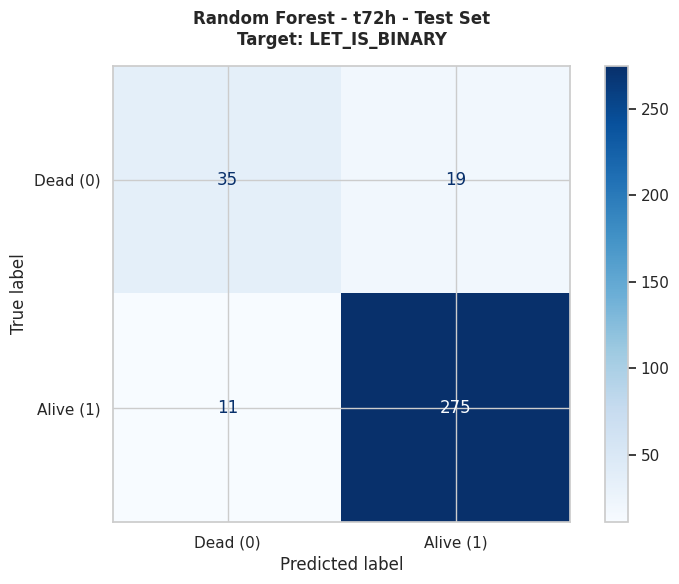

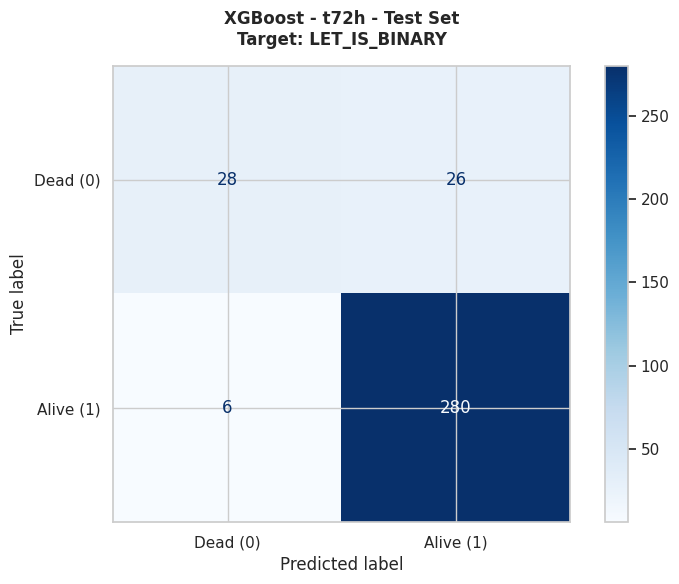

In [69]:
plot_confusion_matrix(
    results_dict["LET_IS_BINARY"]["t72h"]["mean + most_frequent + knn + No Scaling + KNN-5"]["Random Forest"]["test_cm"],
    "Random Forest",
    "t72h",
    "LET_IS_BINARY",
    "Test")
plot_confusion_matrix(
    results_dict["LET_IS_BINARY"]["t72h"]["mean + most_frequent + knn + Scaling + KNN-5"]["XGBoost"]["test_cm"],
    "XGBoost",
    "t72h",
    "LET_IS_BINARY",
    "Test")


Top 5 Results by Test Balanced Acc (descending)


Rank 2/5
Model: Random Forest | Timepoint: t72h
Preprocessing: mean, knn, scaled
Test Balanced Acc: 0.8048


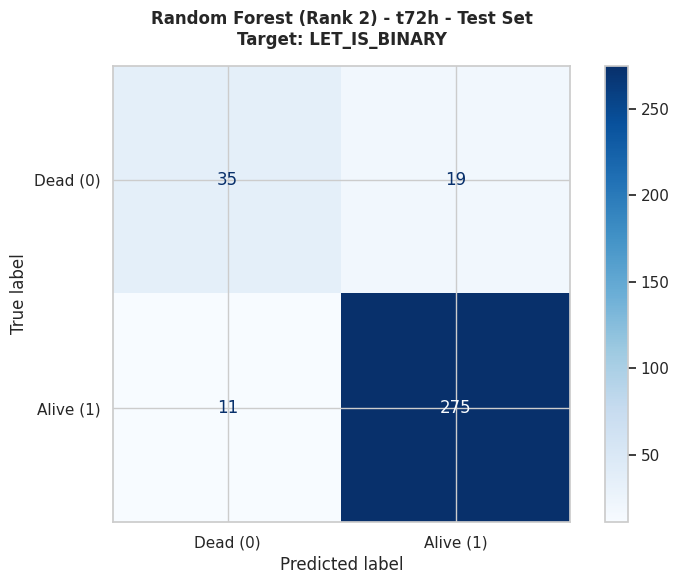


Rank 5/5
Model: Random Forest | Timepoint: t72h
Preprocessing: mean, knn, unscaled
Test Balanced Acc: 0.8048


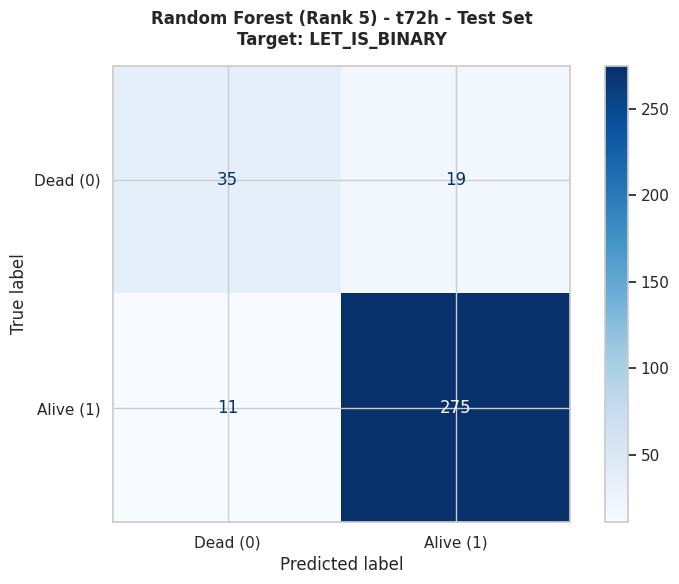


Rank 11/5
Model: Random Forest | Timepoint: t72h
Preprocessing: mean, most_frequent, unscaled
Test Balanced Acc: 0.7846


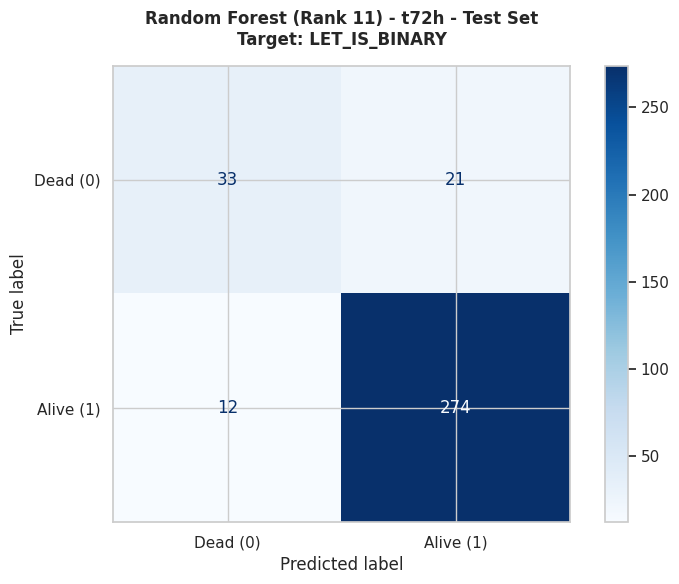


Rank 8/5
Model: Random Forest | Timepoint: t72h
Preprocessing: mean, most_frequent, scaled
Test Balanced Acc: 0.7846


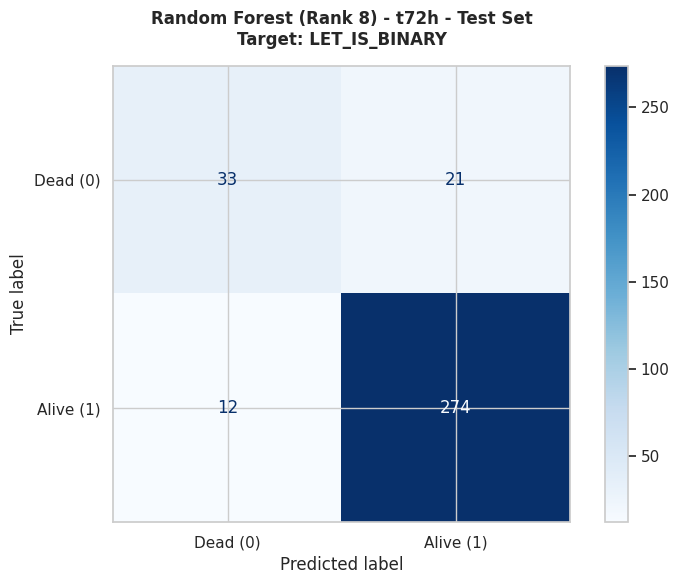


Rank -7/5
Model: Random Forest | Timepoint: t72h
Preprocessing: knn, knn, unscaled
Test Balanced Acc: 0.7678


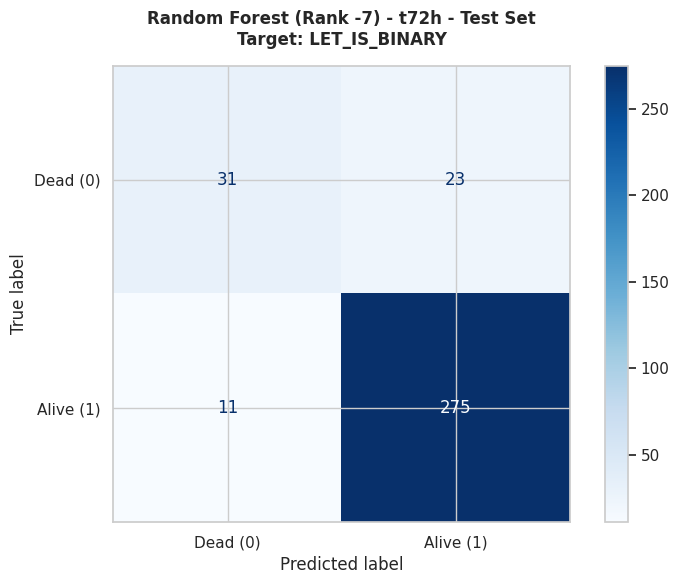

In [70]:
# Example 1: Plot confusion matrices for top 5 results
top_5 = get_top_results(all_results, metric='Test Balanced Acc', top_n=5)
plot_top_n_confusion_matrices(all_results, top_5, n=5, dataset='test')

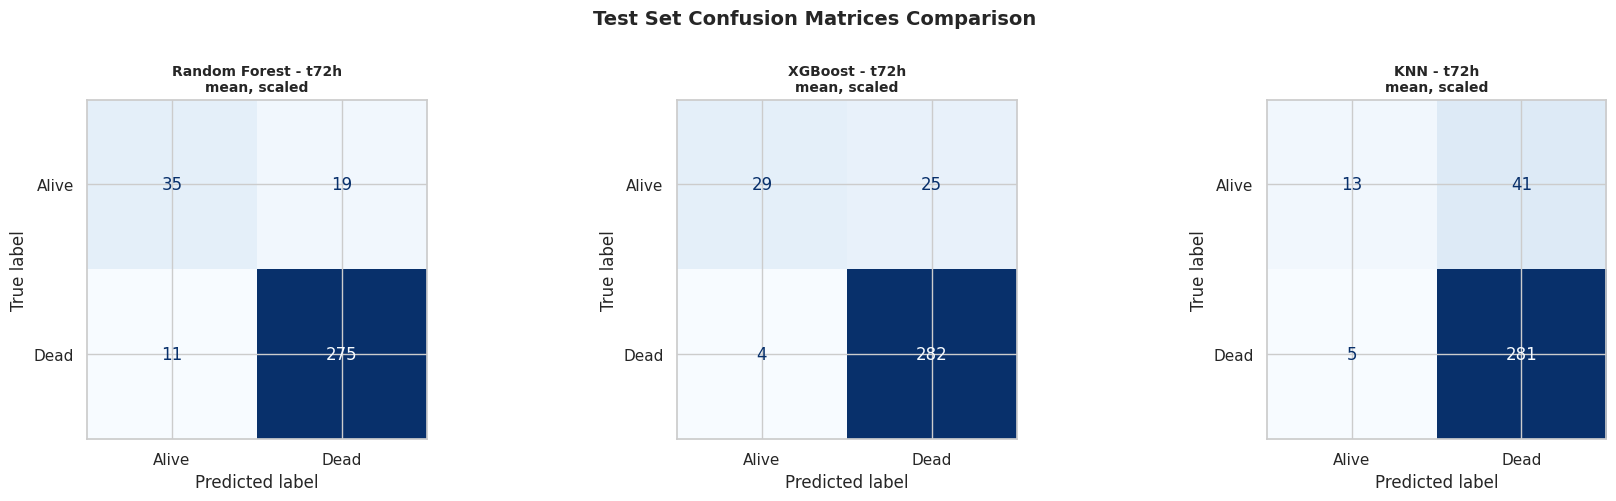

In [71]:
# Example 3: Compare specific configurations side-by-side
compare_cm = []
for index, row in best_per_model.iterrows():
    compare_cm.append({
        "config_name": row["Config"],
        "model_name": row["Model"]
    })

compare_confusion_matrices(all_results, compare_cm, dataset='test')

## 7 Hyperparameter Experimentation on the three Classifiers with best Preprocessor Combination


In [72]:
# The top preprocessing configurations for the three models are:
best_per_model = get_best_per_category(all_results, metric='Test Balanced Acc', category='Model')
display(best_per_model)


Best Result per Model (by Test Balanced Acc)



Config          Model  \
13  LET_IS_BINARY_t72h_mean + most_frequent + knn ...  Random Forest   
20  LET_IS_BINARY_t72h_mean + most_frequent + most...        XGBoost   
12  LET_IS_BINARY_t72h_mean + most_frequent + knn ...            KNN   

   Timepoint         Target Numeric Imputer Binary Imputer  Scaling  \
13      t72h  LET_IS_BINARY            mean            knn     True   
20      t72h  LET_IS_BINARY            mean  most_frequent     True   
12      t72h  LET_IS_BINARY            mean            knn     True   

    KNN Neighbors  Test Accuracy  Test Balanced Acc  Test Precision  \
13              5       0.911765           0.804843        0.935374   
20              5       0.914706           0.761526        0.918567   
12              5       0.864706           0.611629        0.872671   

    Test Recall   Test F1  Train Accuracy  Train Balanced Acc  \
13     0.961538  0.948276        0.978676            0.964914   
20     0.986014  0.951096        1.000000            1.000000   
12     0.982517  0.924342        1.000000            1.000000   

    Train Precision  Train Recall  Train F1  
13         0.989455      0.985127  0.987286  
20         1.000000      1.000000  1.000000  
12         1.000000      1.000000  1.000000

In [73]:
randomForest_preprocessing_params = {
    'numeric_imputer': best_per_model[best_per_model['Model'] == 'Random Forest']['Numeric Imputer'].values[0],
    'binary_imputer': best_per_model[best_per_model['Model'] == 'Random Forest']['Binary Imputer'].values[0],
    'scaling': False,
    'knn_neighbors': best_per_model[best_per_model['Model'] == 'Random Forest']['KNN Neighbors'].values[0],
}
xgboost_preprocessing_params = {
    'numeric_imputer': best_per_model[best_per_model['Model'] == 'XGBoost']['Numeric Imputer'].values[0],
    'binary_imputer': best_per_model[best_per_model['Model'] == 'XGBoost']['Binary Imputer'].values[0],
    'scaling': False,
    'knn_neighbors': best_per_model[best_per_model['Model'] == 'XGBoost']['KNN Neighbors'].values[0],
}
knn_preprocessing_params = {
    'numeric_imputer': best_per_model[best_per_model['Model'] == 'KNN']['Numeric Imputer'].values[0],
    'binary_imputer': best_per_model[best_per_model['Model'] == 'KNN']['Binary Imputer'].values[0],
    'scaling': True,
    'knn_neighbors': best_per_model[best_per_model['Model'] == 'KNN']['KNN Neighbors'].values[0],
}
preprocessing_params = {
    'Random Forest': randomForest_preprocessing_params,
    'XGBoost': xgboost_preprocessing_params,
    'KNN': knn_preprocessing_params,
}
print("Integer Columns:", integer_feature_names)
print("Continuous Columns:", continuous_feature_names)
ordinal_feature_names = [feature for feature in categorical_feature_names if categorical_feature_ordering[feature] == "ordinal"]
nominal_feature_names = [feature for feature in categorical_feature_names if categorical_feature_ordering[feature] == "nominal"]
print("Ordinal Columns:", ordinal_feature_names)
print("Nominal Columns:", nominal_feature_names)
print("Binary Columns:", binary_feature_names)

Integer Columns: ['AGE', 'S_AD_ORIT', 'D_AD_ORIT', 'NA_R_1_n', 'NA_R_2_n', 'NA_R_3_n', 'NOT_NA_2_n', 'NOT_NA_3_n']
Continuous Columns: ['K_BLOOD', 'NA_BLOOD', 'ALT_BLOOD', 'AST_BLOOD', 'L_BLOOD', 'ROE']
Ordinal Columns: ['INF_ANAM', 'STENOK_AN', 'FK_STENOK', 'GB', 'DLIT_AG', 'ZSN_A', 'TIME_B_S', 'R_AB_1_n', 'R_AB_2_n', 'R_AB_3_n', 'NOT_NA_1_n']
Nominal Columns: ['IBS_POST', 'ant_im', 'lat_im', 'inf_im', 'post_im']
Binary Columns: ['SEX', 'IBS_NASL', 'SIM_GIPERT', 'nr_11', 'nr_01', 'nr_02', 'nr_03', 'nr_04', 'nr_07', 'nr_08', 'np_01', 'np_04', 'np_05', 'np_07', 'np_08', 'np_09', 'np_10', 'endocr_01', 'endocr_02', 'endocr_03', 'zab_leg_01', 'zab_leg_02', 'zab_leg_03', 'zab_leg_04', 'zab_leg_06', 'O_L_POST', 'K_SH_POST', 'MP_TP_POST', 'SVT_POST', 'GT_POST', 'FIB_G_POST', 'IM_PG_P', 'ritm_ecg_p_01', 'ritm_ecg_p_02', 'ritm_ecg_p_04', 'ritm_ecg_p_06', 'ritm_ecg_p_07', 'ritm_ecg_p_08', 'n_r_ecg_p_01', 'n_r_ecg_p_02', 'n_r_ecg_p_03', 'n_r_ecg_p_04', 'n_r_ecg_p_05', 'n_r_ecg_p_06', 'n_r_ecg_p_0

In [ ]:
task = "binary"
scoring = get_scorings(task)
refit_metric = "f1_macro"
configs = get_classifier_configs(task)

results_dir = "MI/gridsearch"
os.makedirs(results_dir, exist_ok=True)
all_results = []

for name, cfg in configs.items():
    print(f"Running Grid Search for {name}...")
    preprocessor = build_preprocessor(
        feature_subset = X_train[features_t72],
        numeric_imputer = preprocessing_params[name]['numeric_imputer'],
        categorical_imputer = "most_frequent",
        binary_imputer= preprocessing_params[name]['binary_imputer'],
        scaling = preprocessing_params[name]['scaling'],
        knn_neighbors = preprocessing_params[name]['knn_neighbors']
    )
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', cfg['model'])
    ])

    param_grid = {f'classifier__{k}': v for k, v in cfg['param_grid'].items()}

    gs = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring=scoring,
        refit=refit_metric,
        n_jobs=6,
        verbose=3,
        cv=3
    )

    y_fit = y_train
    gs.fit(X_train, y_fit)

    # Save per-model CV results
    res_df = pd.DataFrame(gs.cv_results_)
    rank_col = f'rank_test_{refit_metric}' if f'rank_test_{refit_metric}' in res_df.columns else ('rank_test_score' if 'rank_test_score' in res_df.columns else None)
    if rank_col is not None:
        res_df = res_df.sort_values(rank_col)
    res_df.insert(0, 'model', name)
    res_df.insert(1, 'scoring', refit_metric)
    res_df['preproc_scaled'] = preprocessing_params[name]['scaling']
    out_path = os.path.join(results_dir, f"{name.replace(' ', '_')}_cv_results_{refit_metric}.csv")
    res_df.to_csv(out_path, index=False)
    all_results.append(res_df)

    print(f"Best parameters for {name}: {gs.best_params_} | Best {refit_metric}: {gs.best_score_:.4f}")

    # Predict and decode if needed
    y_val_pred = gs.predict(X_test)

    print(f"Validation Classification Report for {name}:\n")
    print(classification_report(y_test, y_val_pred, zero_division=0))
    print("-" * 80)

if all_results:
    pd.concat(all_results, ignore_index=True).to_csv(
        os.path.join(results_dir, f"MI_ALL_cv_results_{refit_metric}.csv"),
        index=False
    )

Running Grid Search for KNN...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3] END classifier__n_neighbors=2, classifier__p=1, classifier__weights=uniform; accuracy: (test=0.824) f1_macro: (test=0.681) precision_macro: (test=0.677) recall_macro: (test=0.685) total time=   0.2s
[CV 2/3] END classifier__n_neighbors=2, classifier__p=1, classifier__weights=uniform; accuracy: (test=0.817) f1_macro: (test=0.647) precision_macro: (test=0.652) recall_macro: (test=0.643) total time=   0.2s
[CV 3/3] END classifier__n_neighbors=2, classifier__p=1, classifier__weights=uniform; accuracy: (test=0.804) f1_macro: (test=0.622) precision_macro: (test=0.626) recall_macro: (test=0.618) total time=   0.2s
[CV 1/3] END classifier__n_neighbors=2, classifier__p=1, classifier__weights=distance; accuracy: (test=0.844) f1_macro: (test=0.675) precision_macro: (test=0.703) recall_macro: (test=0.658) total time=   0.2s
[CV 3/3] END classifier__n_neighbors=2, classifier__p=1, classifier__weight

### 5.2 Visualize effects of altering Hyperparameters

In [77]:
# if not all_results:
#     #load all results
results_dir = "MI/gridsearch"
file = "MI_ALL_cv_results_f1_macro.csv"
all_results = pd.read_csv(os.path.join(results_dir, file))

In [78]:
all_results.shape
randomForest_results = all_results[all_results['model'] == 'Random Forest']
#if max_depth is nan, fill with 0
randomForest_results["param_classifier__max_depth"] = randomForest_results["param_classifier__max_depth"].where(
	pd.notnull(randomForest_results["param_classifier__max_depth"]), 0
)
XGBoost_results = all_results[all_results['model'] == 'XGBoost']
KNN_results = all_results[all_results['model'] == 'KNN']

/tmp/ipykernel_511767/1893011958.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  randomForest_results["param_classifier__max_depth"] = randomForest_results["param_classifier__max_depth"].where(


In [79]:
randomForest_params = ["param_classifier__n_estimators", "param_classifier__max_depth"]
XGBoost_params = ["param_classifier__n_estimators", "param_classifier__max_depth", "param_classifier__learning_rate"]
KNN_params = ["param_classifier__n_neighbors", "param_classifier__weights", "param_classifier__p"]

In [80]:
randomForest_best = randomForest_results.loc[randomForest_results['rank_test_f1_macro'] == 1].iloc[0]
randomForest_best_params = {
    'n_estimators': randomForest_best['param_classifier__n_estimators'].astype(int),
    'max_depth': randomForest_best['param_classifier__max_depth'].astype(int)
}
XGBoost_best = XGBoost_results.loc[XGBoost_results['rank_test_f1_macro'] == 1].iloc[0]
XGBoost_best_params = {
    'n_estimators': XGBoost_best['param_classifier__n_estimators'].astype(int),
    'max_depth': XGBoost_best['param_classifier__max_depth'].astype(int),
    'learning_rate': XGBoost_best['param_classifier__learning_rate']
}
KNN_best = KNN_results.loc[KNN_results['rank_test_f1_macro'] == 1].iloc[0]
KNN_best_params = {
    'n_neighbors': KNN_best['param_classifier__n_neighbors'].astype(int),
    'weights': KNN_best['param_classifier__weights'],
    'p': KNN_best['param_classifier__p'].astype(int)
}

def plot_hyperparameter_effects(results_df, model_name, hyperparams, best_params):
    n = len(hyperparams)
    fig, axs = plt.subplots(1, n, figsize=(6 * n, 5), squeeze=False)
    axs = axs[0]

    for i, param in enumerate(hyperparams):
        ax = axs[i]
        subset = results_df.copy()
        for other_param in hyperparams:
            if other_param != param:
                subset = subset[
                    subset[other_param] == best_params[other_param.replace('param_classifier__', '')]
                ]

        sub = subset.dropna(subset=[param, 'mean_test_f1_macro'])

        # Try to treat numeric params as numeric even if dtype=object
        is_numeric = pd.api.types.is_numeric_dtype(sub[param])
        if not is_numeric:
            coerced = pd.to_numeric(sub[param], errors='coerce')
            if coerced.notna().sum() == len(sub):
                sub[param] = coerced
                is_numeric = True

        if is_numeric:
            sub = sub.sort_values(by=param)
            sns.lineplot(data=sub, x=param, y='mean_test_f1_macro', marker='o', ax=ax)
        else:
            sns.barplot(data=sub, x=param, y='mean_test_f1_macro', ax=ax)
            ax.tick_params(axis='x', rotation=45)

        clean_name = param.replace('param_classifier__', '')
        ax.set_title(clean_name)
        ax.set_xlabel(clean_name)
        if i == 0:
            ax.set_ylabel('Mean F1 Macro')
        else:
            ax.set_ylabel('')
        ax.grid(True, linestyle='--', alpha=0.4)

    fig.suptitle(f'Hyperparameter effects for {model_name}', y=1.03)
    fig.tight_layout()
# ...existing code...

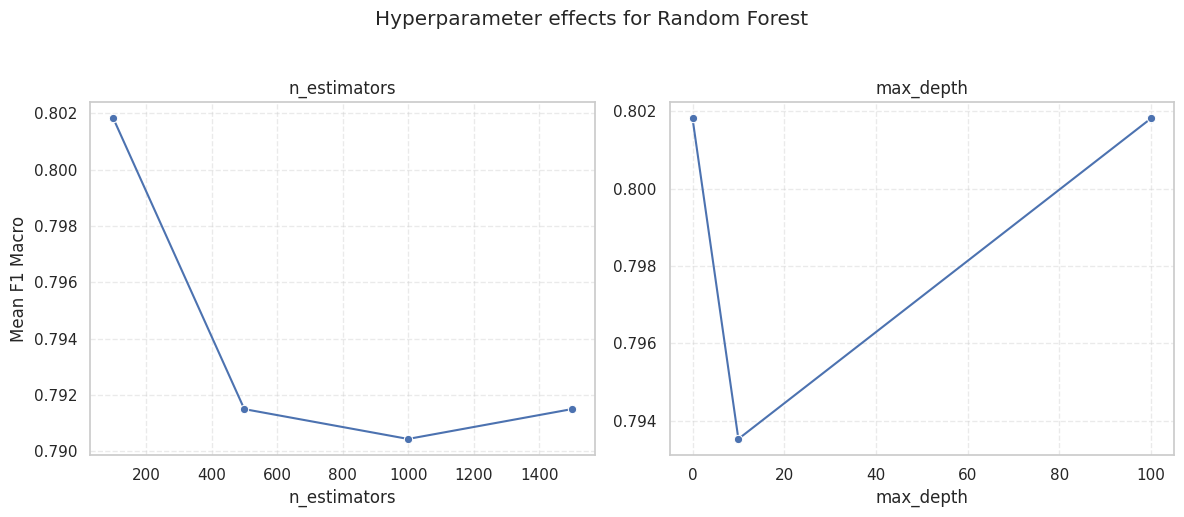

In [81]:
plot_hyperparameter_effects(randomForest_results, 'Random Forest', randomForest_params, randomForest_best_params)

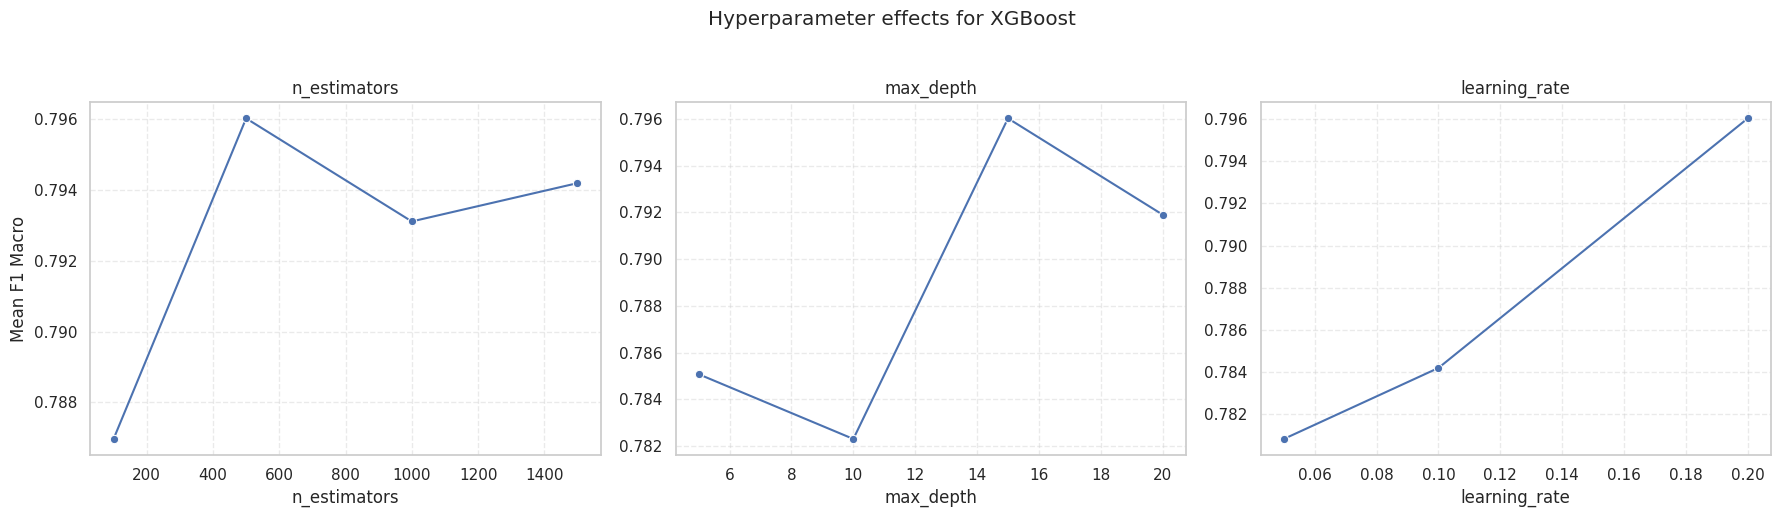

In [82]:
plot_hyperparameter_effects(XGBoost_results, 'XGBoost', XGBoost_params, XGBoost_best_params)

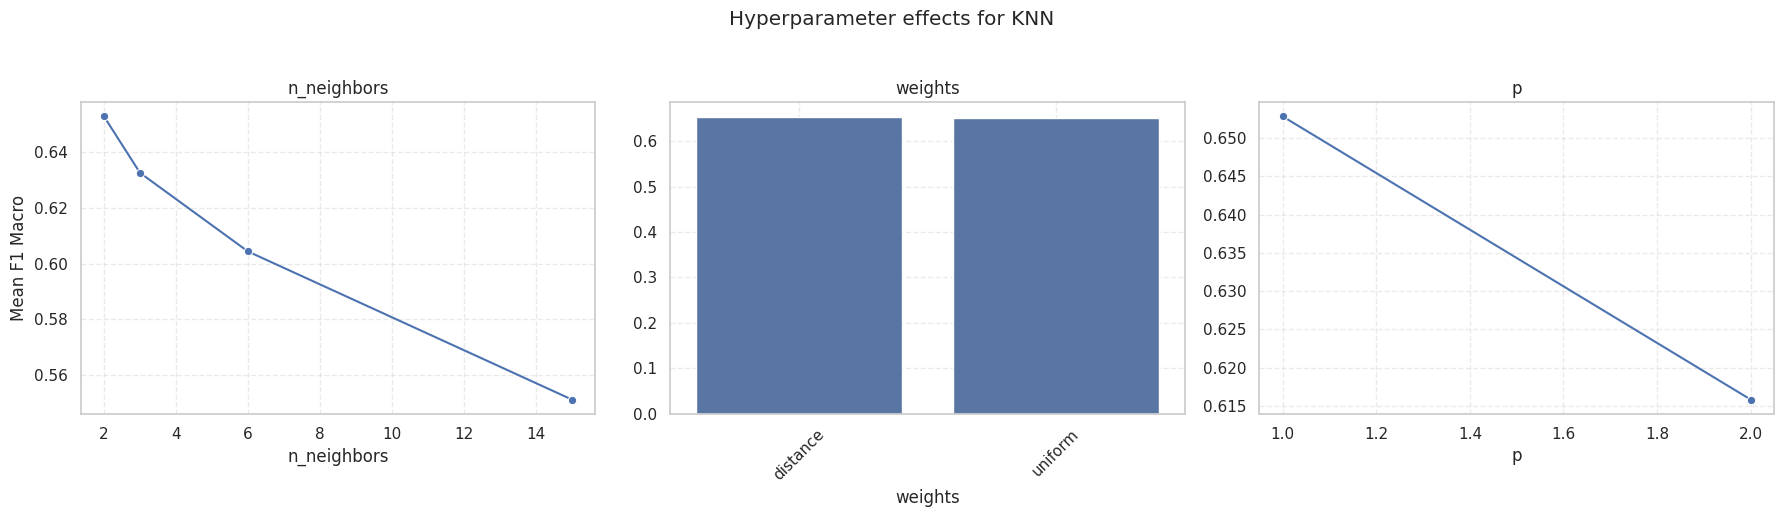

In [83]:
plot_hyperparameter_effects(KNN_results, 'KNN', KNN_params, KNN_best_params)

### 5.3 Best performing Model

In [84]:
#print the best performing model and its parameters
print("Best Performing Models:")
print(f"Random Forest: F1 Macro = {randomForest_best['mean_test_f1_macro']:.4f}, Params = {randomForest_best_params}")
print(f"XGBoost: F1 Macro = {XGBoost_best['mean_test_f1_macro']:.4f}, Params = {XGBoost_best_params}")
print(f"KNN: F1 Macro = {KNN_best['mean_test_f1_macro']:.4f}, Params = {KNN_best_params}")

Best Performing Models:
Random Forest: F1 Macro = 0.8018, Params = {'n_estimators': np.int64(100), 'max_depth': np.int64(0)}
XGBoost: F1 Macro = 0.7960, Params = {'n_estimators': np.int64(500), 'max_depth': np.int64(15), 'learning_rate': np.float64(0.2)}
KNN: F1 Macro = 0.6528, Params = {'n_neighbors': np.int64(2), 'weights': 'distance', 'p': np.int64(1)}


In [88]:
randomForest_best_params["max_depth"] = None

In [95]:
#Train best model on full training data and evaluate on test set

# Train all best performing model on full training data and evaluate on test set
best_models = {
    'Random Forest': 
        (RandomForestClassifier(
            max_features=None,
            bootstrap=True,
            criterion='entropy',
            oob_score=True,
            n_jobs=-1,
            random_state=42,
            **randomForest_best_params), randomForest_best_params),
    'XGBoost': 
        (XGBClassifier(
            objective='binary:logistic',
            eval_metric='logloss',
            n_jobs=-1,
            random_state=42,
            **XGBoost_best_params), XGBoost_best_params),
    'KNN': (KNeighborsClassifier(**KNN_best_params), KNN_best_params)
}
for model_name, (model, params) in best_models.items():
    print(f"Training and evaluating best {model_name} model...")
    scale_TF = model_name.lower().startswith('knn')  # Scale only for KNN
    preprocessor = build_preprocessor(
        feature_subset = X_train[features_t72],
        numeric_imputer = preprocessing_params[name]['numeric_imputer'],
        categorical_imputer = "most_frequent",
        binary_imputer= preprocessing_params[name]['binary_imputer'],
        scaling = preprocessing_params[name]['scaling'],
        knn_neighbors = preprocessing_params[name]['knn_neighbors']
    )
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    y_fit = y_train
    pipe.fit(X_train, y_fit)

    # Predict and decode if needed
    y_test_pred = pipe.predict(X_test)

    print(f"Test Classification Report for {model_name}:\n")
    print(classification_report(y_test, y_test_pred, zero_division=0))
    print("-" * 80)

Training and evaluating best Random Forest model...
Test Classification Report for Random Forest:

              precision    recall  f1-score   support

       False       0.81      0.54      0.64        54
        True       0.92      0.98      0.95       286

    accuracy                           0.91       340
   macro avg       0.86      0.76      0.80       340
weighted avg       0.90      0.91      0.90       340

--------------------------------------------------------------------------------
Training and evaluating best XGBoost model...
Test Classification Report for XGBoost:

              precision    recall  f1-score   support

       False       0.79      0.56      0.65        54
        True       0.92      0.97      0.95       286

    accuracy                           0.91       340
   macro avg       0.86      0.76      0.80       340
weighted avg       0.90      0.91      0.90       340

-------------------------------------------------------------------------------

## 11 Compare best Model (Hyperparameter and Preprocessing): Hold out vs. K-fold Crossvalidation

### 11.1 Hold-out for Random Forest

In [102]:
#Train best Random Forest model und Holdout once
X = X_train
y = y_train
features = timepoint_features["t72h"]
features = [f for f in features if f in X.columns]
X_subset = X[features].copy()

X_holdout = X_test[features].copy()
y_holdout = y_test.copy()
preprocessor = build_preprocessor(
    feature_subset = X_subset,
    numeric_imputer = preprocessing_params['Random Forest']['numeric_imputer'],
    categorical_imputer = "most_frequent",
    binary_imputer= preprocessing_params['Random Forest']['binary_imputer'],
    scaling = preprocessing_params['Random Forest']['scaling'],
    knn_neighbors = preprocessing_params['Random Forest']['knn_neighbors']
)
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        max_features=None,
        bootstrap=True,
        criterion='entropy',
        oob_score=True,
        n_jobs=-1,
        random_state=42,
        **randomForest_best_params))
])
y_fit = y_train
pipe.fit(X_subset, y_fit)
# Predict and decode if needed
y_holdout_pred = pipe.predict(X_holdout)
print(f"Holdout Classification Report for Random Forest:\n")
print(classification_report(y_holdout, y_holdout_pred, zero_division=0))


Holdout Classification Report for Random Forest:

              precision    recall  f1-score   support

       False       0.83      0.56      0.67        54
        True       0.92      0.98      0.95       286

    accuracy                           0.91       340
   macro avg       0.88      0.77      0.81       340
weighted avg       0.91      0.91      0.90       340



### 11.2 Cross Validation for Random Forest

In [103]:
def perform_cross_validation(
    X,
    y,
    timepoint="t72h",
    model_name="Random Forest",
    model_config=models_config,
    numeric_imputer="mean",
    categorical_imputer="most_frequent",
    binary_imputer="knn",
    scaling=False,
    knn_neighbors=5,
    cv_folds=5,
    scoring=['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1'],
    random_state=42
):
    """
    Perform stratified k-fold cross-validation on a model configuration.
    
    Parameters:
    -----------
    X : DataFrame
        Feature data
    y : Series
        Target data
    timepoint : str
        Timepoint to use (e.g., "t0h", "t72h")
    model_name : str
        Name of the model to use
    model_config : dict
        Dictionary mapping model names to model instances
    numeric_imputer : str
        Imputation method for numeric features
    categorical_imputer : str
        Imputation method for categorical features
    binary_imputer : str
        Imputation method for binary features
    scaling : bool
        Whether to apply StandardScaler
    knn_neighbors : int
        Number of neighbors for KNN imputation
    cv_folds : int, default=5
        Number of cross-validation folds
    scoring : list, default=['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1']
        Metrics to compute
    random_state : int, default=42
        Random state for reproducibility
        
    Returns:
    --------
    cv_results : dict
        Dictionary with cross-validation results including:
        - Mean and std for each metric
        - Individual fold scores
        - Confusion matrices for each fold
    """
    print(f"\n{'='*80}")
    print(f"Cross-Validation: {cv_folds}-Fold Stratified K-Fold")
    print(f"{'='*80}")
    print(f"Model: {model_name}")
    print(f"Timepoint: {timepoint}")
    print(f"Preprocessing: numeric={numeric_imputer}, binary={binary_imputer}, scaling={scaling}")
    print(f"{'='*80}\n")
    
    # Get features for timepoint
    features = timepoint_features[timepoint]
    features = [f for f in features if f in X.columns]
    X_subset = X[features].copy()
    
    # Build preprocessor
    preprocessor = build_preprocessor(
        feature_subset=features,
        numeric_imputer=numeric_imputer,
        categorical_imputer=categorical_imputer,
        binary_imputer=binary_imputer,
        scaling=scaling,
        knn_neighbors=knn_neighbors
    )
    
    # Get model
    base_model = model_config[model_name]
    
    # Create pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', base_model)
    ])
    
    # Setup stratified k-fold
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)
    
    # Storage for results
    fold_results = {
        'accuracy': [],
        'balanced_accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusion_matrices': []
    }
    
    # Perform cross-validation
    print("Running cross-validation...")
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_subset, y), 1):
        print(f"\nFold {fold}/{cv_folds}...")
        
        # Split data
        X_train_fold = X_subset.iloc[train_idx]
        X_val_fold = X_subset.iloc[val_idx]
        y_train_fold = y.iloc[train_idx]
        y_val_fold = y.iloc[val_idx]
        
        # Train
        pipeline.fit(X_train_fold, y_train_fold)
        
        # Predict
        y_pred = pipeline.predict(X_val_fold)
        
        # Evaluate
        metrics, report, cm = evaluate_model(y_val_fold, y_pred)
        
        # Store results
        fold_results['accuracy'].append(metrics['accuracy'])
        fold_results['balanced_accuracy'].append(metrics['balanced_accuracy'])
        fold_results['precision'].append(metrics['precision'])
        fold_results['recall'].append(metrics['recall'])
        fold_results['f1'].append(metrics['f1_score'])
        fold_results['confusion_matrices'].append(cm)
        fold_results['classification_reports'] = fold_results.get('classification_reports', []) + [report]
        
        # Print fold results
        print(f"  Accuracy: {metrics['accuracy']:.4f}")
        print(f"  Balanced Acc: {metrics['balanced_accuracy']:.4f}")
        print(f"  Precision: {metrics['precision']:.4f}")
        print(f"  Recall: {metrics['recall']:.4f}")
        print(f"  F1: {metrics['f1_score']:.4f}")
    
    # Compute summary statistics
    cv_results = {
        'model': model_name,
        'timepoint': timepoint,
        'preprocessing': {
            'numeric_imputer': numeric_imputer,
            'categorical_imputer': categorical_imputer,
            'binary_imputer': binary_imputer,
            'scaling': scaling,
            'knn_neighbors': knn_neighbors
        },
        'cv_folds': cv_folds,
        'fold_scores': fold_results,
        'summary': {}
    }
    
    # Calculate mean and std for each metric
    for metric in ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1']:
        scores = fold_results[metric]
        cv_results['summary'][metric] = {
            'mean': np.mean(scores),
            'std': np.std(scores),
            'min': np.min(scores),
            'max': np.max(scores),
            'scores': scores
        }
    
    # Print summary
    print(f"\n{'='*80}")
    print("CROSS-VALIDATION SUMMARY")
    print(f"{'='*80}")
    for metric in ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1']:
        summary = cv_results['summary'][metric]
        print(f"{metric.replace('_', ' ').title():20s}: "
              f"{summary['mean']:.4f} ± {summary['std']:.4f} "
              f"(min: {summary['min']:.4f}, max: {summary['max']:.4f})")
    print(f"{'='*80}\n")
    
    return cv_results


def plot_cv_results(cv_results, figsize=(14, 5)):
    """
    Visualize cross-validation results with box plots and confusion matrices.
    
    Parameters:
    -----------
    cv_results : dict
        Results from perform_cross_validation()
    figsize : tuple, default=(14, 5)
        Figure size
    """
    # Create figure with subplots
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(1, 2, width_ratios=[1, 1.2])
    
    # --- LEFT: Box plot of metrics ---
    ax1 = fig.add_subplot(gs[0])
    
    metrics_data = []
    metrics_names = []
    for metric in ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1']:
        metrics_data.append(cv_results['summary'][metric]['scores'])
        metrics_names.append(metric.replace('_', ' ').title())
    
    bp = ax1.boxplot(metrics_data, labels=metrics_names, patch_artist=True)
    
    # Color the boxes
    colors = sns.color_palette("Set2", len(metrics_names))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    ax1.set_ylabel('Score', fontsize=11)
    ax1.set_title(f'{cv_results["cv_folds"]}-Fold CV Results\n{cv_results["model"]} - {cv_results["timepoint"]}',
                  fontsize=12, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)
    ax1.set_ylim(0, 1)
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # --- RIGHT: Average confusion matrix ---
    ax2 = fig.add_subplot(gs[1])
    
    # Average the confusion matrices
    cms = cv_results['fold_scores']['confusion_matrices']
    avg_cm = np.mean(cms, axis=0)
    
    # Determine labels
    if avg_cm.shape[0] == 2:
        labels = ["Dead (0)", "Alive (1)"]
    else:
        labels = None
    
    disp = ConfusionMatrixDisplay(confusion_matrix=avg_cm.astype(int), display_labels=labels)
    disp.plot(ax=ax2, cmap='Blues', values_format='d', colorbar=True)
    ax2.set_title(f'Average Confusion Matrix\n(Across {cv_results["cv_folds"]} Folds)',
                  fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

In [104]:
models_config_best = {
    "Random Forest": RandomForestClassifier(
        max_features=None,
        bootstrap=True,
        criterion='entropy',
        oob_score=True,
        n_jobs=-1,
        random_state=42,
        **randomForest_best_params
    ),
    "XGBoost": XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        n_jobs=-1,
        random_state=42,
        **XGBoost_best_params
    ),
    "KNN": KNeighborsClassifier(**KNN_best_params)
}


Cross-Validation: 10-Fold Stratified K-Fold
Model: Random Forest
Timepoint: t72h
Preprocessing: numeric=mean, binary=knn, scaling=False

Running cross-validation...

Fold 1/10...
  Accuracy: 0.9000
  Balanced Acc: 0.7903
  Precision: 0.9315
  Recall: 0.9510
  F1: 0.9412

Fold 2/10...
  Accuracy: 0.9000
  Balanced Acc: 0.7753
  Precision: 0.9257
  Recall: 0.9580
  F1: 0.9416

Fold 3/10...
  Accuracy: 0.9176
  Balanced Acc: 0.8008
  Precision: 0.9329
  Recall: 0.9720
  F1: 0.9521

Fold 4/10...
  Accuracy: 0.9118
  Balanced Acc: 0.7823
  Precision: 0.9267
  Recall: 0.9720
  F1: 0.9488

Fold 5/10...
  Accuracy: 0.9118
  Balanced Acc: 0.7673
  Precision: 0.9211
  Recall: 0.9790
  F1: 0.9492

Fold 6/10...
  Accuracy: 0.8882
  Balanced Acc: 0.6782
  Precision: 0.8924
  Recall: 0.9860
  F1: 0.9369

Fold 7/10...
  Accuracy: 0.9118
  Balanced Acc: 0.7823
  Precision: 0.9267
  Recall: 0.9720
  F1: 0.9488

Fold 8/10...
  Accuracy: 0.8824
  Balanced Acc: 0.7198
  Precision: 0.9073
  Recall: 0.9580

/tmp/ipykernel_511767/939453073.py:202: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax1.boxplot(metrics_data, labels=metrics_names, patch_artist=True)


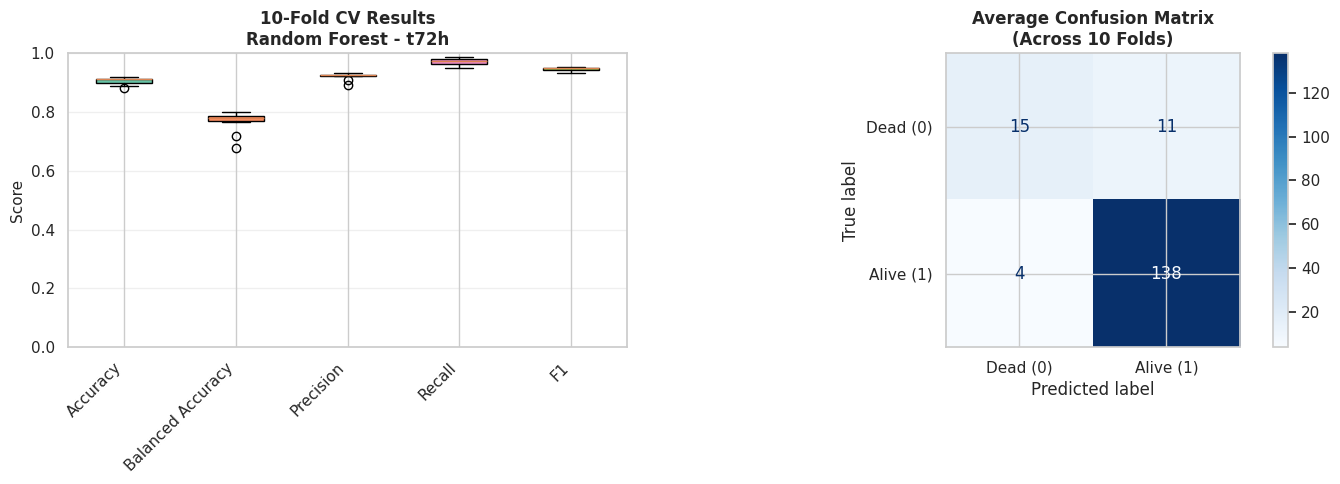

In [105]:
# Perform cross-validation on the best configuration
cv_results = perform_cross_validation(
    X=mi_features_cleaned,
    y=mi_targets[target],
    timepoint="t72h",
    model_name="Random Forest",
    model_config=models_config,
    numeric_imputer="mean",
    categorical_imputer="most_frequent",
    binary_imputer="knn",
    scaling=False,
    knn_neighbors=5,
    cv_folds=10,
    random_state=42
)

# Visualize results
plot_cv_results(cv_results)

In [108]:
for report in cv_results["fold_scores"]["classification_reports"]:
    print(report)
    print("-" * 80)

{'False': {'precision': 0.7083333333333334, 'recall': 0.6296296296296297, 'f1-score': 0.6666666666666666, 'support': 27.0}, 'True': {'precision': 0.9315068493150684, 'recall': 0.951048951048951, 'f1-score': 0.9411764705882353, 'support': 143.0}, 'accuracy': 0.9, 'macro avg': {'precision': 0.8199200913242009, 'recall': 0.7903392903392903, 'f1-score': 0.803921568627451, 'support': 170.0}, 'weighted avg': {'precision': 0.8960616438356164, 'recall': 0.9, 'f1-score': 0.8975778546712803, 'support': 170.0}}
--------------------------------------------------------------------------------
{'False': {'precision': 0.7272727272727273, 'recall': 0.5925925925925926, 'f1-score': 0.6530612244897959, 'support': 27.0}, 'True': {'precision': 0.9256756756756757, 'recall': 0.958041958041958, 'f1-score': 0.9415807560137457, 'support': 143.0}, 'accuracy': 0.9, 'macro avg': {'precision': 0.8264742014742015, 'recall': 0.7753172753172752, 'f1-score': 0.7973209902517708, 'support': 170.0}, 'weighted avg': {'prec


Cross-Validation: 10-Fold Stratified K-Fold
Model: XGBoost
Timepoint: t72h
Preprocessing: numeric=mean, binary=knn, scaling=True

Running cross-validation...

Fold 1/10...
  Accuracy: 0.9294
  Balanced Acc: 0.8228
  Precision: 0.9396
  Recall: 0.9790
  F1: 0.9589

Fold 2/10...
  Accuracy: 0.9294
  Balanced Acc: 0.8078
  Precision: 0.9338
  Recall: 0.9860
  F1: 0.9592

Fold 3/10...
  Accuracy: 0.9176
  Balanced Acc: 0.7858
  Precision: 0.9272
  Recall: 0.9790
  F1: 0.9524

Fold 4/10...
  Accuracy: 0.9235
  Balanced Acc: 0.7893
  Precision: 0.9276
  Recall: 0.9860
  F1: 0.9559

Fold 5/10...
  Accuracy: 0.9000
  Balanced Acc: 0.7453
  Precision: 0.9145
  Recall: 0.9720
  F1: 0.9424

Fold 6/10...
  Accuracy: 0.8941
  Balanced Acc: 0.6817
  Precision: 0.8931
  Recall: 0.9930
  F1: 0.9404

Fold 7/10...
  Accuracy: 0.8941
  Balanced Acc: 0.7268
  Precision: 0.9085
  Recall: 0.9720
  F1: 0.9392

Fold 8/10...
  Accuracy: 0.8824
  Balanced Acc: 0.7047
  Precision: 0.9020
  Recall: 0.9650
  F1: 

/tmp/ipykernel_511767/3489382661.py:201: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax1.boxplot(metrics_data, labels=metrics_names, patch_artist=True)


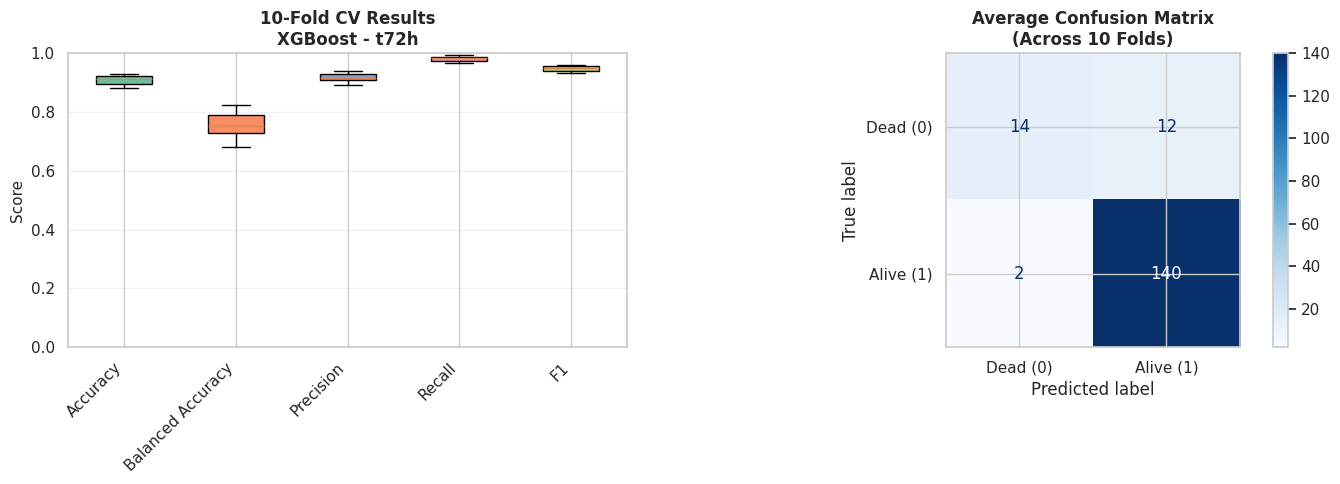

In [99]:
# Perform cross-validation on the best configuration
cv_results = perform_cross_validation(
    X=mi_features_cleaned,
    y=mi_targets[target],
    timepoint="t72h",
    model_name="XGBoost",
    model_config=models_config,
    numeric_imputer="mean",
    categorical_imputer="most_frequent",
    binary_imputer="knn",
    scaling=True,
    knn_neighbors=5,
    cv_folds=10,
    random_state=42
)

# Visualize results
plot_cv_results(cv_results)


Cross-Validation: 10-Fold Stratified K-Fold
Model: KNN
Timepoint: t72h
Preprocessing: numeric=mean, binary=knn, scaling=True

Running cross-validation...

Fold 1/10...
  Accuracy: 0.8706
  Balanced Acc: 0.6076
  Precision: 0.8712
  Recall: 0.9930
  F1: 0.9281

Fold 2/10...
  Accuracy: 0.8294
  Balanced Acc: 0.5531
  Precision: 0.8562
  Recall: 0.9580
  F1: 0.9043

Fold 3/10...
  Accuracy: 0.8412
  Balanced Acc: 0.5300
  Precision: 0.8494
  Recall: 0.9860
  F1: 0.9126

Fold 4/10...
  Accuracy: 0.8647
  Balanced Acc: 0.5891
  Precision: 0.8659
  Recall: 0.9930
  F1: 0.9251

Fold 5/10...
  Accuracy: 0.8588
  Balanced Acc: 0.5856
  Precision: 0.8650
  Recall: 0.9860
  F1: 0.9216

Fold 6/10...
  Accuracy: 0.8353
  Balanced Acc: 0.5115
  Precision: 0.8443
  Recall: 0.9860
  F1: 0.9097

Fold 7/10...
  Accuracy: 0.8824
  Balanced Acc: 0.6447
  Precision: 0.8820
  Recall: 0.9930
  F1: 0.9342

Fold 8/10...
  Accuracy: 0.8529
  Balanced Acc: 0.5521
  Precision: 0.8554
  Recall: 0.9930
  F1: 0.91

/tmp/ipykernel_511767/3489382661.py:201: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax1.boxplot(metrics_data, labels=metrics_names, patch_artist=True)


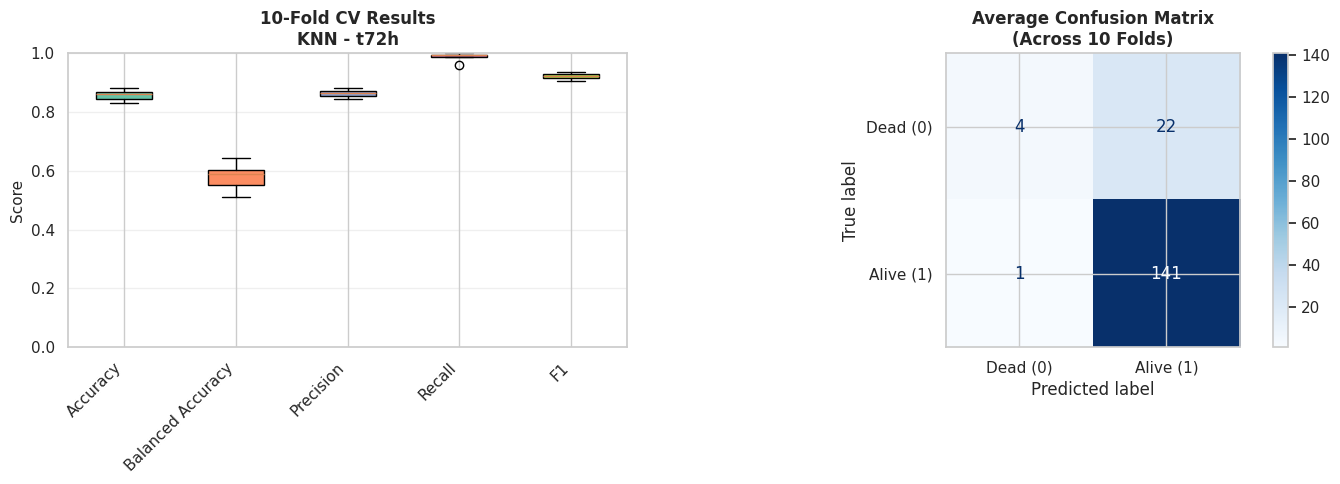

In [100]:
# Perform cross-validation on the best configuration
cv_results = perform_cross_validation(
    X=mi_features_cleaned,
    y=mi_targets[target],
    timepoint="t72h",
    model_name="KNN",
    model_config=models_config,
    numeric_imputer="mean",
    categorical_imputer="most_frequent",
    binary_imputer="knn",
    scaling=True,
    knn_neighbors=5,
    cv_folds=10,
    random_state=42
)

# Visualize results
plot_cv_results(cv_results)